# Contents

[1 Preprocess](#preprocess)

[2 Migration in Texas](#migration)

[3 Local Movement, Outflow, and Other Flows](#local)

[4 Inter-state Movement](#interstate)

[5 Movement Patterns about Education, Race, and Poverty](#socialeco)

# 1 Processing PUMS data to Migration Flow  <a id = "preprocess"></a>

These codes read and preprocess the raw data (csv files) of 2017-2021 PUMS data into population flows

## Load packages

In [514]:
import glob
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import mapclassify
import copy
import os
from scipy.spatial import cKDTree
from shapely.geometry import Point,LineString
import us
import contextily as cx
import warnings
from geopy.distance import geodesic as GD
from scipy.stats import pearsonr
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = [15, 15]
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

table_path = "F:/PUMS/Tables/"
GIS_path = "F:/PUMS/GIS_data/"
intermediate_path = table_path + "intermediate_output/"

pd.options.display.max_columns = 200

## Combine separate 5-year PUMS (csv) files to a dataframe

The combined dataframe (df) is very large. Please refer to this [document ](https://usa.ipums.org/usa/resources/codebooks/DataDict1519.pdf) for the meanings of the columns.

In [2]:
# Getting a list of raw csv files starting with "psam_pu"
# These data are 2015-2019 5-year data downloaded from https://www.census.gov/programs-surveys/acs/microdata/access.html
f_ls = glob.glob(table_path+'raw_data/5_years/2015-2019/psam_pus*')

# test the list
df_ls=[]
for f in f_ls:
    print(f)
    df_ls.append(pd.read_csv(f))
    
df = pd.concat(df_ls)

F:/PUMS/Tables/raw_data/5_years/2015-2019\psam_pusa.csv


C:\Users\xiang11\AppData\Local\Temp\ipykernel_19708\2178602487.py:9: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ls.append(pd.read_csv(f))


F:/PUMS/Tables/raw_data/5_years/2015-2019\psam_pusb.csv


C:\Users\xiang11\AppData\Local\Temp\ipykernel_19708\2178602487.py:9: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ls.append(pd.read_csv(f))


F:/PUMS/Tables/raw_data/5_years/2015-2019\psam_pusc.csv


C:\Users\xiang11\AppData\Local\Temp\ipykernel_19708\2178602487.py:9: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ls.append(pd.read_csv(f))


F:/PUMS/Tables/raw_data/5_years/2015-2019\psam_pusd.csv


C:\Users\xiang11\AppData\Local\Temp\ipykernel_19708\2178602487.py:9: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ls.append(pd.read_csv(f))


In [3]:
puma = gpd.read_file(GIS_path+'GIS_data/ipums_puma_2010.shp')
migpuma = gpd.read_file(GIS_path+"GIS_data/ipums_migpuma_pwpuma_2010.shp")
puma['PUMA2'] = puma['STATEFIP'] + puma['PUMA']
# combine state code and MIGPUMA code
migpuma['MIGPUMA2'] = migpuma['STATEFIP'] + migpuma['MIGPUMA']
puma_p = gpd.read_file(GIS_path+"GIS_data/puma_p.shp")
migpuma_p = gpd.read_file(GIS_path+"GIS_data/migpuma_p.shp")

In [494]:
SHELDUS = pd.read_csv("F:/SHELDUS/ORIGINAL.csv")
county  = gpd.read_file("D:/Users/xiang11/Documents/GitHub/EvacuationIan/datasets/maincounty/us_conu_county.shp").to_crs('ESRI:102003')
migpuma_county_join = gpd.read_file(GIS_path+"GIS_data/migpuma_p_county.shp").to_crs('ESRI:102003')

In [681]:
state    = gpd.read_file("D:/Users/xiang11/Documents/GitHub/EvacuationIan/datasets/usstate/cb_2018_us_state_500k.shp")
state_TX = state[state["STUSPS"]=="TX"]
state_TX = state_TX.to_crs('ESRI:102003')

Document of the data [document link](https://cemhs.asu.edu/sheldus/metadata)

In [5]:
##['Winter Weather', 'Severe Storm/Thunder Storm', 'Tornado', 'Wind',
##       'Lightning', 'Hail', 'Flooding', 'Heat', 'Drought',
##       'Hurricane/Tropical Storm', 'Fog', 'Coastal', 'Wildfire',
##       'Landslide', 'Avalanche', 'Earthquake', 'Tsunami/Seiche',
##       'Volcano']
## Select Flooding and Hurricane/Tropical Storm
SHELDUS_select = SHELDUS.loc[SHELDUS["Hazard"].isin(["Flooding","Hurricane/Tropical Storm"])].reset_index(drop=True)

In [6]:
SHELDUS_select.head()

State Name County Name County FIPS    Hazard  Year  Month     CropDmg  \
0    ALABAMA     Autauga     '01001'  Flooding  1976      3   833.33000   
1    ALABAMA     Autauga     '01001'  Flooding  1979      3     0.00000   
2    ALABAMA     Autauga     '01001'  Flooding  1982      6     0.00000   
3    ALABAMA     Autauga     '01001'  Flooding  1979      2     0.00000   
4    ALABAMA     Autauga     '01001'  Flooding  1979      4  7246.37667   

   CropDmg(ADJ 2020)  CropDmgPerCapita(ADJ 2020)  PropertyDmg  \
0         3838.88000                     0.12839  83333.33000   
1            0.00000                     0.00000  24875.62333   
2            0.00000                     0.00000    131.58000   
3            0.00000                     0.00000     37.31500   
4        26162.77667                     0.81504  72463.76667   

   PropertyDmg(ADJ 2020)  PropertyDmgPerCapita(ADJ 2020)  Injuries  \
0           383889.32000                        12.83911   0.00000   
1            89812.52667                         2.79790   0.00000   
2              357.40500                         0.01116   0.00000   
3              134.72500                         0.00420   0.00000   
4           261627.77333                         8.15040   0.04333   

   InjuriesPerCapita  Fatalities  FatalitiesPerCapita  Duration_Days  \
0                0.0        0.00                  0.0            2.0   
1                0.0        0.04                  0.0            3.0   
2                0.0        0.00                  0.0            1.0   
3                0.0        0.00                  0.0            1.0   
4                0.0        0.10                  0.0            2.0   

   Fatalities_Duration  Injuries_Duration  Property_Damage_Duration  \
0                  0.0                0.0                       2.0   
1                  3.0                0.0                       3.0   
2                  0.0                0.0                       1.0   
3                  0.0                0.0                       1.0   
4                  2.0                2.0                       2.0   

   Crop_Damage_Duration  Records  
0                   2.0        1  
1                   0.0        1  
2                   0.0        1  
3                   0.0        1  
4                   2.0        1

In [496]:
df_migpuma_county = migpuma_county_join[["State","MIGPUMA2","FIPS"]].reset_index(drop=True)

In [497]:
df_migpuma_county.head()

State MIGPUMA2   FIPS
0  California  0600100  06001
1  California  0600700  06007
2  California  0601100  06103
3  California  0601300  06013
4  California  0601500  06035

## Combine
#### Delete NaN records and store the year of the records in a new column

In [7]:
df1 = df[~df['SERIALNO'].isna()]
df1['year'] = df1['SERIALNO'].astype(str).str[0:4]

In [8]:
df1.head()

RT       SERIALNO  DIVISION  SPORDER  PUMA  REGION  ST   ADJINC  PWGTP  \
0  P  2015000000067         6        1  2701       3   1  1080470      9   
1  P  2015000000067         6        2  2701       3   1  1080470      9   
2  P  2015000000067         6        3  2701       3   1  1080470     12   
3  P  2015000000067         6        4  2701       3   1  1080470     14   
4  P  2015000000160         6        1  1000       3   1  1080470     15   

   AGEP  CIT  CITWP  COW  DDRS  DEAR  DEYE  DOUT  DPHY  DRAT  DRATX  DREM  \
0    56    1    NaN  6.0   2.0     2     2   2.0   1.0   NaN    NaN   2.0   
1    61    1    NaN  NaN   2.0     2     2   2.0   2.0   NaN    NaN   2.0   
2     8    1    NaN  NaN   2.0     2     2   NaN   2.0   NaN    NaN   2.0   
3    61    1    NaN  1.0   2.0     2     2   2.0   2.0   NaN    2.0   2.0   
4    52    1    NaN  NaN   2.0     2     2   2.0   1.0   NaN    NaN   1.0   

   ENG  FER  GCL  GCM  GCR  HINS1  HINS2  HINS3  HINS4  HINS5  HINS6  HINS7  \
0  NaN  NaN  1.0  1.0  1.0      1      2      2      2      2      2      2   
1  NaN  NaN  1.0  NaN  2.0      1      2      2      2      2      2      2   
2  NaN  NaN  NaN  NaN  NaN      2      2      2      1      2      2      2   
3  NaN  NaN  2.0  NaN  NaN      2      2      2      2      2      2      2   
4  NaN  NaN  2.0  NaN  NaN      2      2      2      1      2      2      2   

      INTP  JWMNP  JWRIP  JWTRNS  LANX  MAR  MARHD  MARHM  MARHT  MARHW  \
0      0.0    5.0    1.0     1.0   2.0    1    2.0    2.0    1.0    2.0   
1  14000.0    NaN    NaN     NaN   2.0    1    2.0    2.0    1.0    2.0   
2      NaN    NaN    NaN     NaN   2.0    5    NaN    NaN    NaN    NaN   
3      0.0   20.0    1.0     1.0   2.0    3    2.0    2.0    1.0    2.0   
4      0.0    NaN    NaN     NaN   2.0    3    2.0    2.0    3.0    2.0   

   MARHYP  MIG  MIL  MLPA  MLPB  MLPCD  MLPE  MLPFG  MLPH  MLPI  MLPJ  MLPK  \
0  2002.0  1.0  4.0   NaN   NaN    NaN   NaN    NaN   NaN   NaN   NaN   NaN   
1  2002.0  1.0  4.0   NaN   NaN    NaN   NaN    NaN   NaN   NaN   NaN   NaN   
2     NaN  3.0  NaN   NaN   NaN    NaN   NaN    NaN   NaN   NaN   NaN   NaN   
3  1996.0  1.0  2.0   0.0   0.0    0.0   1.0    0.0   0.0   0.0   0.0   0.0   
4  1991.0  1.0  4.0   NaN   NaN    NaN   NaN    NaN   NaN   NaN   NaN   NaN   

   NWAB  NWAV  NWLA  NWLK  NWRE  OIP  PAP  RELSHIPP  RETP  SCH  SCHG  SCHL  \
0   3.0   5.0   3.0   3.0   3.0  0.0  0.0        20   0.0  1.0   NaN  14.0   
1   3.0   5.0   3.0   3.0   3.0  0.0  0.0        21   0.0  1.0   NaN  19.0   
2   NaN   NaN   NaN   NaN   NaN  NaN  NaN        30   NaN  2.0   5.0   5.0   
3   3.0   5.0   3.0   3.0   3.0  0.0  0.0        34   0.0  1.0   NaN  19.0   
4   2.0   5.0   2.0   3.0   2.0  0.0  0.0        20   0.0  1.0   NaN  11.0   

    SEMP  SEX    SSIP  SSP     WAGP  WKHP  WKL  WKW  WKWN  WRK  YOEP  ANC  \
0  650.0    1     0.0  0.0   2800.0   5.0  1.0  1.0   NaN  NaN   NaN    4   
1    0.0    2     0.0  0.0      0.0   NaN  3.0  NaN   NaN  NaN   NaN    4   
2    NaN    2     NaN  NaN      NaN   NaN  NaN  NaN   NaN  NaN   NaN    4   
3    0.0    1     0.0  0.0  35000.0  40.0  1.0  1.0   NaN  NaN   NaN    4   
4    0.0    2  8800.0  0.0      0.0   NaN  3.0  NaN   NaN  2.0   NaN    2   

   ANC1P  ANC2P  DECADE  DIS  DRIVESP  ESP  ESR  FOD1P  FOD2P  HICOV  HISP  \
0    999    999     NaN    1      1.0  NaN  1.0    NaN    NaN      1     1   
1    999    999     NaN    2      NaN  NaN  6.0    NaN    NaN      1     1   
2    999    999     NaN    2      NaN  NaN  NaN    NaN    NaN      1     1   
3    999    999     NaN    2      1.0  NaN  1.0    NaN    NaN      2     1   
4    924    920     NaN    1      NaN  NaN  6.0    NaN    NaN      1     1   

     INDP  JWAP  JWDP  LANP  MIGPUMA  MIGSP  MSP NAICSP  NATIVITY  NOP   OC  \
0  9160.0  90.0  50.0   NaN      NaN    NaN  1.0   8131         1  NaN  0.0   
1     NaN   NaN   NaN   NaN      NaN    NaN  1.0    NaN         1  NaN  0.0   
2     NaN   NaN   NaN   NaN   2700.0    1.0

SCHL POVPIP RACE

### Read and preprocess PUMA-MIGPUMA conversion table

Find more information about PUMA, MIGPUMA and changes of PUMA areas from [here](https://engagedscholarship.csuohio.edu/cgi/viewcontent.cgi?article=1419&context=urban_facpub) and [here](https://www.census.gov/content/dam/Census/library/publications/2020/acs/acs_pums_handbook_2020_ch02.pdf).

In [9]:
# Read the PUMA <-> MIGPUMA crosswalk table
# We used 2010 data for Hurricane Harvey
trans = pd.read_csv(table_path+"Tables-selected/PUMA_MIGPUMA/2010/puma_migpuma1_pwpuma00_2010.csv")

Rename some column names.

In [10]:
# state/country of PUMA
trans = trans.rename(columns={"Place of Work State (PWSTATE2) or Migration State (MIGPLAC1)": "MIGSP"})
# Migpuma (county or group of counties)
trans = trans.rename(columns={"PWPUMA00 or MIGPUMA1": "MIGPUMA"})
# State of PUMA
trans = trans.rename(columns={"State of Residence (ST)": "ST"})

Format PUMA, State, MIGSP and MIGPUMA codes

In [11]:
# PUMA of current residence
trans['PUMA'] = trans['PUMA'].astype('int64').astype('str').str.rjust(5, "0")
# State of current residence
trans['ST'] = trans['ST'].astype('int16').astype('str').str.rjust(2, "0")
# State or country of migration PUMA
trans['MIGSP'] = trans['MIGSP'].astype('int64').astype('str').str.rjust(2, "0")
# Migration PUMA
trans['MIGPUMA'] = trans['MIGPUMA'].astype('int64').astype('str').str.rjust(5, "0")

Combine State/country with PUMA and MIGPUMA to a composite code

In [12]:
trans['PUMA2'] = trans['ST'] + trans['PUMA']
trans['MIGPUMA2'] = trans['MIGSP'] + trans['MIGPUMA']

In [13]:
trans

ST   PUMA MIGSP MIGPUMA    PUMA2 MIGPUMA2
0     01  00100    01   00190  0100100  0100190
1     01  00200    01   00290  0100200  0100290
2     01  00301    01   00290  0100301  0100290
3     01  00302    01   00290  0100302  0100290
4     01  00400    01   00400  0100400  0100400
...   ..    ...   ...     ...      ...      ...
2373  72  00902    72   00900  7200902  7200900
2374  72  01001    72   01001  7201001  7201001
2375  72  01002    72   01002  7201002  7201002
2376  72  01101    72   01101  7201101  7201101
2377  72  01102    72   01102  7201102  7201102

[2378 rows x 6 columns]

#### Remove records without migration data (non_migrants)

In [14]:
df2 = df1.dropna(subset=['MIGPUMA'])

Format MIGPUMA codes to be joined with the crosswalk table (trans).

In [15]:
# Format MIGPUMA codes
df2.loc[:,'MIGPUMA'] = df2['MIGPUMA'].astype('int64').astype('str').str.rjust(5, "0")
df2.loc[:,'PUMA'] = df2['PUMA'].astype('int64').astype('str').str.rjust(5, "0")
df2.loc[:,'MIGSP'] = df2['MIGSP'].astype('int64').astype('str').str.rjust(2, "0")
df2.loc[:,'ST'] = df2['ST'].astype('int64').astype('str').str.rjust(2, "0")

C:\Users\xiang11\AppData\Local\Temp\ipykernel_19708\1555462554.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.loc[:,'MIGPUMA'] = df2['MIGPUMA'].astype('int64').astype('str').str.rjust(5, "0")
C:\Users\xiang11\AppData\Local\Temp\ipykernel_19708\1555462554.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.loc[:,'PUMA'] = df2['PUMA'].astype('int64').astype('str').str.rjust(5, "0")
C:\Users\xiang11\AppData\Local\Temp\ipykernel_19708\1555462554.py:4: SettingWithCopyWarning: 
A value is trying to b

In [16]:
# Concatenate State and PUMA codes to unique codes for PUMA and MIGPUMA
# Origins are MIGPUMA, Destinations (current residence) are regular PUMA

df2.loc[:,'PUMA_D'] = df2['ST'] + df2['PUMA']
df2.loc[:,'MIGPUMA_O'] = df2['MIGSP'] + df2['MIGPUMA']

C:\Users\xiang11\AppData\Local\Temp\ipykernel_19708\1588349914.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.loc[:,'PUMA_D'] = df2['ST'] + df2['PUMA']
C:\Users\xiang11\AppData\Local\Temp\ipykernel_19708\1588349914.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.loc[:,'MIGPUMA_O'] = df2['MIGSP'] + df2['MIGPUMA']


In [17]:
# Merge PUMS data with the PUMA-MIGPUMA conversion table
# Rename column names
df2 = pd.merge(df2,trans,how='left',left_on='PUMA_D',right_on='PUMA2').drop(['ST_y','PUMA_y','MIGSP_y','MIGPUMA_y','PUMA2']
                                                                            ,axis=1).rename(columns={"MIGPUMA2": "MIGPUMA_D"})

In [18]:
df2.head()

RT       SERIALNO  DIVISION  SPORDER PUMA_x  REGION ST_x   ADJINC  PWGTP  \
0  P  2015000000067         6        3  02701       3   01  1080470     12   
1  P  2015000001052         6        1  02600       3   01  1080470      4   
2  P  2015000001890         6        1  01900       3   01  1080470      4   
3  P  2015000001898         6        2  00600       3   01  1080470     16   
4  P  2015000002757         6        1  02500       3   01  1080470      9   

   AGEP  CIT  CITWP  COW  DDRS  DEAR  DEYE  DOUT  DPHY  DRAT  DRATX  DREM  \
0     8    1    NaN  NaN   2.0     2     2   NaN   2.0   NaN    NaN   2.0   
1    47    1    NaN  1.0   2.0     2     2   2.0   2.0   NaN    2.0   2.0   
2    18    1    NaN  1.0   2.0     2     2   2.0   2.0   NaN    NaN   2.0   
3    21    1    NaN  1.0   2.0     2     2   2.0   2.0   NaN    NaN   2.0   
4    56    1    NaN  NaN   2.0     2     2   2.0   2.0   NaN    NaN   1.0   

   ENG  FER  GCL  GCM  GCR  HINS1  HINS2  HINS3  HINS4  HINS5  HINS6  HINS7  \
0  NaN  NaN  NaN  NaN  NaN      2      2      2      1      2      2      2   
1  NaN  NaN  2.0  NaN  NaN      2      2      2      1      2      2      2   
2  NaN  2.0  NaN  NaN  NaN      2      1      2      2      2      2      2   
3  NaN  NaN  NaN  NaN  NaN      1      2      2      2      2      2      2   
4  NaN  NaN  2.0  NaN  NaN      2      2      2      1      2      2      2   

   INTP  JWMNP  JWRIP  JWTRNS  LANX  MAR  MARHD  MARHM  MARHT  MARHW  MARHYP  \
0   NaN    NaN    NaN     NaN   2.0    5    NaN    NaN    NaN    NaN     NaN   
1   0.0    NaN    NaN     NaN   2.0    2    2.0    2.0    1.0    2.0  2006.0   
2   0.0    NaN    NaN     NaN   2.0    5    NaN    NaN    NaN    NaN     NaN   
3   0.0  130.0    1.0     1.0   2.0    5    NaN    NaN    NaN    NaN     NaN   
4   0.0    NaN    NaN     NaN   2.0    1    2.0    2.0    1.0    2.0  1996.0   

   MIG  MIL  MLPA  MLPB  MLPCD  MLPE  MLPFG  MLPH  MLPI  MLPJ  MLPK  NWAB  \
0  3.0  NaN   NaN   NaN    NaN   NaN    NaN   NaN   NaN   NaN   NaN   NaN   
1  3.0  3.0   NaN   NaN    NaN   NaN    NaN   NaN   NaN   NaN   NaN   2.0   
2  3.0  4.0   NaN   NaN    NaN   NaN    NaN   NaN   NaN   NaN   NaN   2.0   
3  3.0  4.0   NaN   NaN    NaN   NaN    NaN   NaN   NaN   NaN   NaN   3.0   
4  3.0  4.0   NaN   NaN    NaN   NaN    NaN   NaN   NaN   NaN   NaN   2.0   

   NWAV  NWLA  NWLK  NWRE  OIP  PAP  RELSHIPP  RETP  SCH  SCHG  SCHL  SEMP  \
0   NaN   NaN   NaN   NaN  NaN  NaN        30   NaN  2.0   5.0   5.0   NaN   
1   5.0   2.0   2.0   3.0  0.0  0.0        38   0.0  1.0   NaN  16.0   0.0   
2   5.0   2.0   2.0   3.0  0.0  0.0        38   0.0  2.0  15.0  16.0   0.0   
3   5.0   3.0   3.0   3.0  0.0  0.0        33   0.0  1.0   NaN  16.0   0.0   
4   5.0   2.0   2.0   3.0  0.0  0.0        20   0.0  1.0   NaN  11.0   0.0   

   SEX    SSIP  SSP     WAGP  WKHP  WKL  WKW  WKWN  WRK  YOEP  ANC  ANC1P  \
0    2     NaN  NaN      NaN   NaN  NaN  NaN   NaN  NaN   NaN    4    999   
1    1     0.0  0.0      0.0   NaN  2.0  NaN   NaN  2.0   NaN    1    902   
2    2     0.0  0.0  30000.0  12.0  1.0  1.0   NaN  2.0   NaN    1     26   
3    1     0.0  0.0  10000.0  40.0  1.0  1.0   NaN  1.0   NaN    1    924   
4    2  8200.0  0.0      0.0   NaN  3.0  NaN   NaN  2.0   NaN    1    902   

   ANC2P  DECADE  DIS  DRIVESP  ESP  ESR  FOD1P  FOD2P  HICOV  HISP    INDP  \
0    999     NaN    2      NaN  NaN  NaN    NaN    NaN      1     1     NaN   
1    999     NaN    2      NaN  NaN  6.0    NaN    NaN      1     1  3570.0   
2    999     NaN    2      NaN  NaN  6.0    NaN    NaN      1     1  8680.0   
3    999     NaN    2      1.0  NaN  1.0    NaN    NaN      1     1  5381.0   
4    999     NaN    1      NaN  NaN  6.0    NaN    NaN      1     1     NaN   

    JWAP  JWDP  LANP MIGPUMA_x MIGSP_x  MSP NAICSP  NATIVITY  NOP   OC  \
0    NaN   NaN   NaN     02700      01  NaN    NaN         1  NaN  0.0   
1    NaN   NaN   NaN     02400      01  3.0   336M         1  NaN  0.0   
2    NaN   NaN   NaN  

In [16]:
# Export data to a csv file
df2.to_csv(intermediate_path+'df15_19.csv')

# Preview 
df2.head()

RT       SERIALNO  DIVISION  SPORDER PUMA_x  REGION ST_x   ADJINC  PWGTP  \
0  P  2015000000067         6        3  02701       3   01  1080470     12   
1  P  2015000001052         6        1  02600       3   01  1080470      4   
2  P  2015000001890         6        1  01900       3   01  1080470      4   
3  P  2015000001898         6        2  00600       3   01  1080470     16   
4  P  2015000002757         6        1  02500       3   01  1080470      9   

   AGEP  CIT  CITWP  COW  DDRS  DEAR  DEYE  DOUT  DPHY  DRAT  DRATX  DREM  \
0     8    1    NaN  NaN   2.0     2     2   NaN   2.0   NaN    NaN   2.0   
1    47    1    NaN  1.0   2.0     2     2   2.0   2.0   NaN    2.0   2.0   
2    18    1    NaN  1.0   2.0     2     2   2.0   2.0   NaN    NaN   2.0   
3    21    1    NaN  1.0   2.0     2     2   2.0   2.0   NaN    NaN   2.0   
4    56    1    NaN  NaN   2.0     2     2   2.0   2.0   NaN    NaN   1.0   

   ENG  FER  GCL  GCM  GCR  HINS1  HINS2  HINS3  HINS4  HINS5  HINS6  HINS7  \
0  NaN  NaN  NaN  NaN  NaN      2      2      2      1      2      2      2   
1  NaN  NaN  2.0  NaN  NaN      2      2      2      1      2      2      2   
2  NaN  2.0  NaN  NaN  NaN      2      1      2      2      2      2      2   
3  NaN  NaN  NaN  NaN  NaN      1      2      2      2      2      2      2   
4  NaN  NaN  2.0  NaN  NaN      2      2      2      1      2      2      2   

   INTP  JWMNP  JWRIP  JWTRNS  LANX  MAR  MARHD  MARHM  MARHT  MARHW  MARHYP  \
0   NaN    NaN    NaN     NaN   2.0    5    NaN    NaN    NaN    NaN     NaN   
1   0.0    NaN    NaN     NaN   2.0    2    2.0    2.0    1.0    2.0  2006.0   
2   0.0    NaN    NaN     NaN   2.0    5    NaN    NaN    NaN    NaN     NaN   
3   0.0  130.0    1.0     1.0   2.0    5    NaN    NaN    NaN    NaN     NaN   
4   0.0    NaN    NaN     NaN   2.0    1    2.0    2.0    1.0    2.0  1996.0   

   MIG  MIL  MLPA  MLPB  MLPCD  MLPE  MLPFG  MLPH  MLPI  MLPJ  MLPK  NWAB  \
0  3.0  NaN   NaN   NaN    NaN   NaN    NaN   NaN   NaN   NaN   NaN   NaN   
1  3.0  3.0   NaN   NaN    NaN   NaN    NaN   NaN   NaN   NaN   NaN   2.0   
2  3.0  4.0   NaN   NaN    NaN   NaN    NaN   NaN   NaN   NaN   NaN   2.0   
3  3.0  4.0   NaN   NaN    NaN   NaN    NaN   NaN   NaN   NaN   NaN   3.0   
4  3.0  4.0   NaN   NaN    NaN   NaN    NaN   NaN   NaN   NaN   NaN   2.0   

   NWAV  NWLA  NWLK  NWRE  OIP  PAP  RELSHIPP  RETP  SCH  SCHG  SCHL  SEMP  \
0   NaN   NaN   NaN   NaN  NaN  NaN        30   NaN  2.0   5.0   5.0   NaN   
1   5.0   2.0   2.0   3.0  0.0  0.0        38   0.0  1.0   NaN  16.0   0.0   
2   5.0   2.0   2.0   3.0  0.0  0.0        38   0.0  2.0  15.0  16.0   0.0   
3   5.0   3.0   3.0   3.0  0.0  0.0        33   0.0  1.0   NaN  16.0   0.0   
4   5.0   2.0   2.0   3.0  0.0  0.0        20   0.0  1.0   NaN  11.0   0.0   

   SEX    SSIP  SSP     WAGP  WKHP  WKL  WKW  WKWN  WRK  YOEP  ANC  ANC1P  \
0    2     NaN  NaN      NaN   NaN  NaN  NaN   NaN  NaN   NaN    4    999   
1    1     0.0  0.0      0.0   NaN  2.0  NaN   NaN  2.0   NaN    1    902   
2    2     0.0  0.0  30000.0  12.0  1.0  1.0   NaN  2.0   NaN    1     26   
3    1     0.0  0.0  10000.0  40.0  1.0  1.0   NaN  1.0   NaN    1    924   
4    2  8200.0  0.0      0.0   NaN  3.0  NaN   NaN  2.0   NaN    1    902   

   ANC2P  DECADE  DIS  DRIVESP  ESP  ESR  FOD1P  FOD2P  HICOV  HISP    INDP  \
0    999     NaN    2      NaN  NaN  NaN    NaN    NaN      1     1     NaN   
1    999     NaN    2      NaN  NaN  6.0    NaN    NaN      1     1  3570.0   
2    999     NaN    2      NaN  NaN  6.0    NaN    NaN      1     1  8680.0   
3    999     NaN    2      1.0  NaN  1.0    NaN    NaN      1     1  5381.0   
4    999     NaN    1      NaN  NaN  6.0    NaN    NaN      1     1     NaN   

    JWAP  JWDP  LANP MIGPUMA_x MIGSP_x  MSP NAICSP  NATIVITY  NOP   OC  \
0    NaN   NaN   NaN     02700      01  NaN    NaN         1  NaN  0.0   
1    NaN   NaN   NaN     02400      01  3.0   336M         1  NaN  0.0   
2    NaN   NaN   NaN  

### Migration in Texas <a id = "migration"></a>

### Affected MIGPUMA
Here I only selected the migpuma located in affected area.
The datasource is from FEMA website.

### Calculate O-D pairs

In [31]:
df2.head()

RT       SERIALNO  DIVISION  SPORDER PUMA_x  REGION ST_x   ADJINC  PWGTP  \
0  P  2015000000067         6        3  02701       3   01  1080470     12   
1  P  2015000001052         6        1  02600       3   01  1080470      4   
2  P  2015000001890         6        1  01900       3   01  1080470      4   
3  P  2015000001898         6        2  00600       3   01  1080470     16   
4  P  2015000002757         6        1  02500       3   01  1080470      9   

   AGEP  CIT  CITWP  COW  DDRS  DEAR  DEYE  DOUT  DPHY  DRAT  DRATX  DREM  \
0     8    1    NaN  NaN   2.0     2     2   NaN   2.0   NaN    NaN   2.0   
1    47    1    NaN  1.0   2.0     2     2   2.0   2.0   NaN    2.0   2.0   
2    18    1    NaN  1.0   2.0     2     2   2.0   2.0   NaN    NaN   2.0   
3    21    1    NaN  1.0   2.0     2     2   2.0   2.0   NaN    NaN   2.0   
4    56    1    NaN  NaN   2.0     2     2   2.0   2.0   NaN    NaN   1.0   

   ENG  FER  GCL  GCM  GCR  HINS1  HINS2  HINS3  HINS4  HINS5  HINS6  HINS7  \
0  NaN  NaN  NaN  NaN  NaN      2      2      2      1      2      2      2   
1  NaN  NaN  2.0  NaN  NaN      2      2      2      1      2      2      2   
2  NaN  2.0  NaN  NaN  NaN      2      1      2      2      2      2      2   
3  NaN  NaN  NaN  NaN  NaN      1      2      2      2      2      2      2   
4  NaN  NaN  2.0  NaN  NaN      2      2      2      1      2      2      2   

   INTP  JWMNP  JWRIP  JWTRNS  LANX  MAR  MARHD  MARHM  MARHT  MARHW  MARHYP  \
0   NaN    NaN    NaN     NaN   2.0    5    NaN    NaN    NaN    NaN     NaN   
1   0.0    NaN    NaN     NaN   2.0    2    2.0    2.0    1.0    2.0  2006.0   
2   0.0    NaN    NaN     NaN   2.0    5    NaN    NaN    NaN    NaN     NaN   
3   0.0  130.0    1.0     1.0   2.0    5    NaN    NaN    NaN    NaN     NaN   
4   0.0    NaN    NaN     NaN   2.0    1    2.0    2.0    1.0    2.0  1996.0   

   MIG  MIL  MLPA  MLPB  MLPCD  MLPE  MLPFG  MLPH  MLPI  MLPJ  MLPK  NWAB  \
0  3.0  NaN   NaN   NaN    NaN   NaN    NaN   NaN   NaN   NaN   NaN   NaN   
1  3.0  3.0   NaN   NaN    NaN   NaN    NaN   NaN   NaN   NaN   NaN   2.0   
2  3.0  4.0   NaN   NaN    NaN   NaN    NaN   NaN   NaN   NaN   NaN   2.0   
3  3.0  4.0   NaN   NaN    NaN   NaN    NaN   NaN   NaN   NaN   NaN   3.0   
4  3.0  4.0   NaN   NaN    NaN   NaN    NaN   NaN   NaN   NaN   NaN   2.0   

   NWAV  NWLA  NWLK  NWRE  OIP  PAP  RELSHIPP  RETP  SCH  SCHG  SCHL  SEMP  \
0   NaN   NaN   NaN   NaN  NaN  NaN        30   NaN  2.0   5.0   5.0   NaN   
1   5.0   2.0   2.0   3.0  0.0  0.0        38   0.0  1.0   NaN  16.0   0.0   
2   5.0   2.0   2.0   3.0  0.0  0.0        38   0.0  2.0  15.0  16.0   0.0   
3   5.0   3.0   3.0   3.0  0.0  0.0        33   0.0  1.0   NaN  16.0   0.0   
4   5.0   2.0   2.0   3.0  0.0  0.0        20   0.0  1.0   NaN  11.0   0.0   

   SEX    SSIP  SSP     WAGP  WKHP  WKL  WKW  WKWN  WRK  YOEP  ANC  ANC1P  \
0    2     NaN  NaN      NaN   NaN  NaN  NaN   NaN  NaN   NaN    4    999   
1    1     0.0  0.0      0.0   NaN  2.0  NaN   NaN  2.0   NaN    1    902   
2    2     0.0  0.0  30000.0  12.0  1.0  1.0   NaN  2.0   NaN    1     26   
3    1     0.0  0.0  10000.0  40.0  1.0  1.0   NaN  1.0   NaN    1    924   
4    2  8200.0  0.0      0.0   NaN  3.0  NaN   NaN  2.0   NaN    1    902   

   ANC2P  DECADE  DIS  DRIVESP  ESP  ESR  FOD1P  FOD2P  HICOV  HISP    INDP  \
0    999     NaN    2      NaN  NaN  NaN    NaN    NaN      1     1     NaN   
1    999     NaN    2      NaN  NaN  6.0    NaN    NaN      1     1  3570.0   
2    999     NaN    2      NaN  NaN  6.0    NaN    NaN      1     1  8680.0   
3    999     NaN    2      1.0  NaN  1.0    NaN    NaN      1     1  5381.0   
4    999     NaN    1      NaN  NaN  6.0    NaN    NaN      1     1     NaN   

    JWAP  JWDP  LANP MIGPUMA_x MIGSP_x  MSP NAICSP  NATIVITY  NOP   OC  \
0    NaN   NaN   NaN     02700      01  NaN    NaN         1  NaN  0.0   
1    NaN   NaN   NaN     02400      01  3.0   336M         1  NaN  0.0   
2    NaN   NaN   NaN  

In [32]:
df_od = df2.groupby(["MIGPUMA_O","year","MIGPUMA_D"]).agg({"PWGTP":"sum"}).reset_index()
df_od

MIGPUMA_O  year MIGPUMA_D  PWGTP
0        0100190  2015   0100190   6259
1        0100190  2015   0100290    373
2        0100190  2015   0100400      3
3        0100190  2015   0100600    344
4        0100190  2015   0100700     29
...          ...   ...       ...    ...
262166   7200002  2019   5311700     38
262167   7200002  2019   5400300    131
262168   7200002  2019   5401200     22
262169   7200002  2019   5501400     30
262170   7200002  2019   5540100     26

[262171 rows x 4 columns]

In [111]:
migpuma_texas = migpuma[migpuma["State"]=="Texas"]
migpuma_texas_list = list(migpuma_texas.MIGPUMA2.unique())
affected_migpuma   = ["4803601","4803602","4803900","4804100","4804200","4804300","4804400","4804500","4804600",
                      "4804700","4804800","4804900","4805000","4805100","4805500","4805600","4806500","4806600"]
other_migpuma_texas= [i for i in migpuma_texas_list if i not in affected_migpuma]
df_migpuma_af = migpuma[migpuma["MIGPUMA2"].isin(df_af_migpuma)].reset_index()
migpuma_affect_list = list(df_migpuma_af.MIGPUMA2.unique())
df_migpuma_oth= migpuma[migpuma["MIGPUMA2"].isin(other_migpuma_texas)].reset_index()
migpuma_other_list = list(df_migpuma_oth.MIGPUMA2.unique())

In [47]:
df_flow_in_texas_1 = df_od.loc[df_od["MIGPUMA_O"].isin(migpuma_texas_list)]
df_flow_in_texas   = df_flow_in_texas_1.loc[df_flow_in_texas_1["MIGPUMA_D"].isin(migpuma_texas_list)].reset_index(drop=True)

In [82]:
df_flow_in_texas_2015 = df_flow_in_texas.loc[df_flow_in_texas["year"].isin(["2015"])].reset_index(drop=True)
df_flow_in_texas_2016 = df_flow_in_texas.loc[df_flow_in_texas["year"].isin(["2016"])].reset_index(drop=True)
df_flow_in_texas_2017 = df_flow_in_texas.loc[df_flow_in_texas["year"].isin(["2017"])].reset_index(drop=True)
df_flow_in_texas_2018 = df_flow_in_texas.loc[df_flow_in_texas["year"].isin(["2018"])].reset_index(drop=True)
df_flow_in_texas_2019 = df_flow_in_texas.loc[df_flow_in_texas["year"].isin(["2019"])].reset_index(drop=True)

Calculate the net movement in each year

In [81]:
def net_pop(df):
    df["O_D"] = df["MIGPUMA_O"]+df["MIGPUMA_D"]
    df["D_O"] = df["MIGPUMA_D"]+df["MIGPUMA_O"]
    df_New = pd.DataFrame()
    for i in range(len(df)):
        calc = df[df["D_O"].str.contains(df["O_D"][i])]
        if calc.empty == False:
            new = calc
        else:
            new = pd.DataFrame({"MIGPUMA_O":"0","year":"2019","MIGPUMA_D":"0","PWGTP":0,"O_D":"0","D_O":"0"},index=[i])
        df_New = df_New.append(new)
    df_New = df_New.reset_index(drop=True)
    df["PWGTP2"] = df_New["PWGTP"]
    df["net_pop"] = df["PWGTP"] - df["PWGTP2"]
    df = df[df["net_pop"]>0]
    df = df[["MIGPUMA_O","year","MIGPUMA_D","PWGTP","PWGTP2","net_pop"]]
    return df

In [83]:
df_flow_in_texas_2015_net = net_pop(df_flow_in_texas_2015)
df_flow_in_texas_2016_net = net_pop(df_flow_in_texas_2016)
df_flow_in_texas_2017_net = net_pop(df_flow_in_texas_2017)
df_flow_in_texas_2018_net = net_pop(df_flow_in_texas_2018)
df_flow_in_texas_2019_net = net_pop(df_flow_in_texas_2019)

In [87]:
def uniqueName(df):
    name = str(df.year.unique()[0])
    df = df.rename(columns={"MIGPUMA_O": "MIGPUMA_O_"+name,
                            "year":"year_"+name,
                            "MIGPUMA_D":"MIGPUMA_D_"+name,
                            "PWGTP":"PWGTP_"+name,
                            "PWGTP2":"PWGTP2_"+name,
                            "net_pop":"net_pop_"+name})
    return df

In [88]:
df_flow_in_texas_2015_net = uniqueName(df_flow_in_texas_2015_net)
df_flow_in_texas_2016_net = uniqueName(df_flow_in_texas_2016_net)
df_flow_in_texas_2017_net = uniqueName(df_flow_in_texas_2017_net)
df_flow_in_texas_2018_net = uniqueName(df_flow_in_texas_2018_net)
df_flow_in_texas_2019_net = uniqueName(df_flow_in_texas_2019_net)

In [93]:
merge_flow_in_15_16 = pd.merge(df_flow_in_texas_2015_net,df_flow_in_texas_2016_net,left_on=["MIGPUMA_O_2015","MIGPUMA_D_2015"],
                         right_on=["MIGPUMA_O_2016","MIGPUMA_D_2016"],how="outer")
listNum = []
merge_flow_in_15_16 = merge_flow_in_15_16.fillna(0)
for i in range(len(merge_flow_in_15_16)):
    List = []
    List.append(int(merge_flow_in_15_16[i:i+1]["net_pop_2015"]))
    List.append(int(merge_flow_in_15_16[i:i+1]["net_pop_2016"]))
    number = 2 - int(List.count(0))
    listNum.append(number)
merge_flow_in_15_16["countNum"] = listNum
merge_flow_in_15_16["net_pop_AVG"] = (merge_flow_in_15_16["net_pop_2015"]+merge_flow_in_15_16["net_pop_2016"])/merge_flow_in_15_16["countNum"]

In [100]:
list_o = []
list_d = []
for i in range(len(list_o_1)):
    if list_o_1[i] == 0:
        list_o.append(list_o_2[i])
    else:
        list_o.append(list_o_1[i])

for i in range(len(list_d_1)):
    if list_d_1[i] == 0:
        list_d.append(list_d_2[i])
    else:
        list_d.append(list_d_1[i])

In [109]:
df_flow_in_texas_15_16_net = pd.DataFrame(data={
    "MIGPUMA_O_Prior":list_o,
    "MIGPUMA_D_Prior":list_d,
    "net_pop_Prior":list_Pop
})

## Defination:  <a id = "local"></a>
Local: Netflow inside the affected migpumas

Outflow: Netflow from affected migpumas to others inside Texas

Other: Netflow from unaffected migpumas

In [184]:
df_flow_in_texas_15_16_net_local_1 = df_flow_in_texas_15_16_net.loc[df_flow_in_texas_15_16_net["MIGPUMA_O_Prior"].isin(affected_migpuma)]
df_flow_in_texas_15_16_net_local = df_flow_in_texas_15_16_net_local_1.loc[df_flow_in_texas_15_16_net["MIGPUMA_D_Prior"].isin(affected_migpuma)].reset_index(drop=True)

df_flow_in_texas_15_16_net_outflow_1 = df_flow_in_texas_15_16_net.loc[df_flow_in_texas_15_16_net["MIGPUMA_O_Prior"].isin(affected_migpuma)]
df_flow_in_texas_15_16_net_outflow = df_flow_in_texas_15_16_net_outflow_1.loc[df_flow_in_texas_15_16_net["MIGPUMA_D_Prior"].isin(migpuma_other_list)].reset_index(drop=True)

df_flow_in_texas_15_16_net_other = df_flow_in_texas_15_16_net.loc[df_flow_in_texas_15_16_net["MIGPUMA_O_Prior"].isin(migpuma_other_list)].reset_index(drop=True)

df_flow_in_texas_2017_net_local_1 = df_flow_in_texas_2017_net.loc[df_flow_in_texas_2017_net["MIGPUMA_O_2017"].isin(affected_migpuma)]
df_flow_in_texas_2017_net_local = df_flow_in_texas_2017_net_local_1.loc[df_flow_in_texas_2017_net["MIGPUMA_D_2017"].isin(affected_migpuma)].reset_index(drop=True)

df_flow_in_texas_2017_net_outflow_1 = df_flow_in_texas_2017_net.loc[df_flow_in_texas_2017_net["MIGPUMA_O_2017"].isin(affected_migpuma)]
df_flow_in_texas_2017_net_outflow = df_flow_in_texas_2017_net_outflow_1.loc[df_flow_in_texas_2017_net["MIGPUMA_D_2017"].isin(migpuma_other_list)].reset_index(drop=True)

df_flow_in_texas_2017_net_other = df_flow_in_texas_2017_net.loc[df_flow_in_texas_2017_net["MIGPUMA_O_2017"].isin(migpuma_other_list)].reset_index(drop=True)

df_flow_in_texas_2018_net_local_1 = df_flow_in_texas_2018_net.loc[df_flow_in_texas_2018_net["MIGPUMA_O_2018"].isin(affected_migpuma)]
df_flow_in_texas_2018_net_local = df_flow_in_texas_2018_net_local_1.loc[df_flow_in_texas_2018_net["MIGPUMA_D_2018"].isin(affected_migpuma)].reset_index(drop=True)

df_flow_in_texas_2018_net_outflow_1 = df_flow_in_texas_2018_net.loc[df_flow_in_texas_2018_net["MIGPUMA_O_2018"].isin(affected_migpuma)]
df_flow_in_texas_2018_net_outflow = df_flow_in_texas_2018_net_outflow_1.loc[df_flow_in_texas_2018_net["MIGPUMA_D_2018"].isin(migpuma_other_list)].reset_index(drop=True)

df_flow_in_texas_2018_net_other = df_flow_in_texas_2018_net.loc[df_flow_in_texas_2018_net["MIGPUMA_O_2018"].isin(migpuma_other_list)].reset_index(drop=True)

In [186]:
df_flow_in_texas_local_prior_in = pd.merge(df_flow_in_texas_15_16_net_local,df_flow_in_texas_2017_net_local,left_on=["MIGPUMA_O_Prior","MIGPUMA_D_Prior"],right_on=["MIGPUMA_O_2017","MIGPUMA_D_2017"],how="inner")
df_flow_in_texas_local_prior_post1 = pd.merge(df_flow_in_texas_15_16_net_local,df_flow_in_texas_2018_net_local,left_on=["MIGPUMA_O_Prior","MIGPUMA_D_Prior"],right_on=["MIGPUMA_O_2018","MIGPUMA_D_2018"],how="inner")

df_flow_in_texas_outflow_prior_in = pd.merge(df_flow_in_texas_15_16_net_outflow,df_flow_in_texas_2017_net_outflow,left_on=["MIGPUMA_O_Prior","MIGPUMA_D_Prior"],right_on=["MIGPUMA_O_2017","MIGPUMA_D_2017"],how="inner")
df_flow_in_texas_outflow_prior_post1 = pd.merge(df_flow_in_texas_15_16_net_outflow,df_flow_in_texas_2018_net_outflow,left_on=["MIGPUMA_O_Prior","MIGPUMA_D_Prior"],right_on=["MIGPUMA_O_2018","MIGPUMA_D_2018"],how="inner")

df_flow_in_texas_other_prior_in = pd.merge(df_flow_in_texas_15_16_net_other,df_flow_in_texas_2017_net_other,left_on=["MIGPUMA_O_Prior","MIGPUMA_D_Prior"],right_on=["MIGPUMA_O_2017","MIGPUMA_D_2017"],how="inner")
df_flow_in_texas_other_prior_post1 = pd.merge(df_flow_in_texas_15_16_net_other,df_flow_in_texas_2018_net_other,left_on=["MIGPUMA_O_Prior","MIGPUMA_D_Prior"],right_on=["MIGPUMA_O_2018","MIGPUMA_D_2018"],how="inner")

In [188]:
df_flow_in_texas_local_prior_in["cr_prior_in"] = (df_flow_in_texas_local_prior_in["net_pop_2017"] - df_flow_in_texas_local_prior_in["net_pop_Prior"]) / df_flow_in_texas_local_prior_in["net_pop_Prior"]*100
df_flow_in_texas_local_prior_post1["cr_prior_post1"] = (df_flow_in_texas_local_prior_post1["net_pop_2018"] - df_flow_in_texas_local_prior_post1["net_pop_Prior"]) / df_flow_in_texas_local_prior_post1["net_pop_Prior"]*100

df_flow_in_texas_outflow_prior_in["cr_prior_in"] = (df_flow_in_texas_outflow_prior_in["net_pop_2017"] - df_flow_in_texas_outflow_prior_in["net_pop_Prior"]) / df_flow_in_texas_outflow_prior_in["net_pop_Prior"]*100
df_flow_in_texas_outflow_prior_post1["cr_prior_post1"] = (df_flow_in_texas_outflow_prior_post1["net_pop_2018"] - df_flow_in_texas_outflow_prior_post1["net_pop_Prior"]) / df_flow_in_texas_outflow_prior_post1["net_pop_Prior"]*100

df_flow_in_texas_other_prior_in["cr_prior_in"] = (df_flow_in_texas_other_prior_in["net_pop_2017"] - df_flow_in_texas_other_prior_in["net_pop_Prior"]) / df_flow_in_texas_other_prior_in["net_pop_Prior"]*100
df_flow_in_texas_other_prior_post1["cr_prior_post1"] = (df_flow_in_texas_other_prior_post1["net_pop_2018"] - df_flow_in_texas_other_prior_post1["net_pop_Prior"]) / df_flow_in_texas_other_prior_post1["net_pop_Prior"]*100

In [191]:
def df_addxy(df):
    df_1 = pd.merge(df,migpuma_p,left_on="MIGPUMA_O_Prior",right_on="MIGPUMA2")
    df2  = pd.merge(df_1,migpuma_p,left_on="MIGPUMA_D_Prior",right_on="MIGPUMA2")
    return df2

In [192]:
df_flow_in_texas_local_prior_in = df_addxy(df_flow_in_texas_local_prior_in) 
df_flow_in_texas_local_prior_post1 = df_addxy(df_flow_in_texas_local_prior_post1) 
df_flow_in_texas_outflow_prior_in = df_addxy(df_flow_in_texas_outflow_prior_in) 
df_flow_in_texas_outflow_prior_post1 = df_addxy(df_flow_in_texas_outflow_prior_post1) 
df_flow_in_texas_other_prior_in = df_addxy(df_flow_in_texas_other_prior_in) 
df_flow_in_texas_other_prior_post1 = df_addxy(df_flow_in_texas_other_prior_post1) 

In [193]:
df_line = pd.DataFrame()
df_line["geometry"] = df_flow_in_texas_local_prior_in.apply(lambda x: LineString([x["geometry_x"],x["geometry_y"]]),axis=1)
df_line = gpd.GeoDataFrame(df_line,geometry="geometry",crs = 'ESRI:102003').to_crs("EPSG:4326")
df_line[["PWGTP_Prior","PWGTP_In","MIGPUMA_O","MIGPUMA_D"]] = df_flow_in_texas_local_prior_in[["net_pop_Prior","net_pop_2017","MIGPUMA_O_Prior","MIGPUMA_D_Prior"]]
df_line2 = pd.DataFrame()
df_line2["geometry"] = df_flow_in_texas_local_prior_post1.apply(lambda x: LineString([x["geometry_x"],x["geometry_y"]]),axis=1)
df_line2 = gpd.GeoDataFrame(df_line2,geometry="geometry",crs = 'ESRI:102003').to_crs("EPSG:4326")
df_line2[["PWGTP_Prior","PWGTP_Post1","MIGPUMA_O","MIGPUMA_D"]] = df_flow_in_texas_local_prior_post1[["net_pop_Prior","net_pop_2018","MIGPUMA_O_Prior","MIGPUMA_D_Prior"]]

df_line3 = pd.DataFrame()
df_line3["geometry"] = df_flow_in_texas_outflow_prior_in.apply(lambda x: LineString([x["geometry_x"],x["geometry_y"]]),axis=1)
df_line3 = gpd.GeoDataFrame(df_line3,geometry="geometry",crs = 'ESRI:102003').to_crs("EPSG:4326")
df_line3[["PWGTP_Prior","PWGTP_In","MIGPUMA_O","MIGPUMA_D"]] = df_flow_in_texas_outflow_prior_in[["net_pop_Prior","net_pop_2017","MIGPUMA_O_Prior","MIGPUMA_D_Prior"]]
df_line4 = pd.DataFrame()
df_line4["geometry"] = df_flow_in_texas_outflow_prior_post1.apply(lambda x: LineString([x["geometry_x"],x["geometry_y"]]),axis=1)
df_line4 = gpd.GeoDataFrame(df_line4,geometry="geometry",crs = 'ESRI:102003').to_crs("EPSG:4326")
df_line4[["PWGTP_Prior","PWGTP_Post1","MIGPUMA_O","MIGPUMA_D"]] = df_flow_in_texas_outflow_prior_post1[["net_pop_Prior","net_pop_2018","MIGPUMA_O_Prior","MIGPUMA_D_Prior"]]

df_line5 = pd.DataFrame()
df_line5["geometry"] = df_flow_in_texas_other_prior_in.apply(lambda x: LineString([x["geometry_x"],x["geometry_y"]]),axis=1)
df_line5 = gpd.GeoDataFrame(df_line5,geometry="geometry",crs = 'ESRI:102003').to_crs("EPSG:4326")
df_line5[["PWGTP_Prior","PWGTP_In","MIGPUMA_O","MIGPUMA_D"]] = df_flow_in_texas_other_prior_in[["net_pop_Prior","net_pop_2017","MIGPUMA_O_Prior","MIGPUMA_D_Prior"]]
df_line6 = pd.DataFrame()
df_line6["geometry"] = df_flow_in_texas_other_prior_post1.apply(lambda x: LineString([x["geometry_x"],x["geometry_y"]]),axis=1)
df_line6 = gpd.GeoDataFrame(df_line6,geometry="geometry",crs = 'ESRI:102003').to_crs("EPSG:4326")
df_line6[["PWGTP_Prior","PWGTP_Post1","MIGPUMA_O","MIGPUMA_D"]] = df_flow_in_texas_other_prior_post1[["net_pop_Prior","net_pop_2018","MIGPUMA_O_Prior","MIGPUMA_D_Prior"]]

In [195]:
def x_y_o_d(gdf):
    gdf['x_o'] = gdf.geometry.apply(lambda geom: geom.coords[0][0])
    gdf['y_o'] = gdf.geometry.apply(lambda geom: geom.coords[0][1])
    gdf['x_d'] = gdf.geometry.apply(lambda geom: geom.coords[1][0])
    gdf['y_d'] = gdf.geometry.apply(lambda geom: geom.coords[1][1])
    gdf['Dist'] = gdf.apply(lambda row: GD((row['y_o'], row['x_o']), (row['y_d'], row['x_d'])).km, axis=1)
    gdf = gpd.GeoDataFrame(gdf,geometry="geometry",crs ="EPSG:4326" ).to_crs('ESRI:102003')
    gdf['x_o'] = gdf.geometry.apply(lambda geom: geom.coords[0][0])
    gdf['y_o'] = gdf.geometry.apply(lambda geom: geom.coords[0][1])
    gdf['x_d'] = gdf.geometry.apply(lambda geom: geom.coords[1][0])
    gdf['y_d'] = gdf.geometry.apply(lambda geom: geom.coords[1][1])
    return gdf

In [196]:
gdf_local_prior_in      = x_y_o_d(df_line)
gdf_local_prior_post1   = x_y_o_d(df_line2)
gdf_outflow_prior_in    = x_y_o_d(df_line3)
gdf_outflow_prior_post1 = x_y_o_d(df_line4)
gdf_other_prior_in      = x_y_o_d(df_line5)
gdf_other_prior_post1   = x_y_o_d(df_line6)

In [199]:
gdf_local_prior_in["cr_prior_in"] = (gdf_local_prior_in["PWGTP_In"] - gdf_local_prior_in["PWGTP_Prior"]) / gdf_local_prior_in["PWGTP_Prior"]*100
gdf_local_prior_post1["cr_prior_post1"] = (gdf_local_prior_post1["PWGTP_Post1"] - gdf_local_prior_post1["PWGTP_Prior"]) / gdf_local_prior_post1["PWGTP_Prior"]*100

gdf_outflow_prior_in["cr_prior_in"] = (gdf_outflow_prior_in["PWGTP_In"] - gdf_outflow_prior_in["PWGTP_Prior"]) / gdf_outflow_prior_in["PWGTP_Prior"]*100
gdf_outflow_prior_post1["cr_prior_post1"] = (gdf_outflow_prior_post1["PWGTP_Post1"] - gdf_outflow_prior_post1["PWGTP_Prior"]) / gdf_outflow_prior_post1["PWGTP_Prior"]*100

gdf_other_prior_in["cr_prior_in"] = (gdf_other_prior_in["PWGTP_In"] - gdf_other_prior_in["PWGTP_Prior"]) / gdf_other_prior_in["PWGTP_Prior"]*100
gdf_other_prior_post1["cr_prior_post1"] = (gdf_other_prior_post1["PWGTP_Post1"] - gdf_other_prior_post1["PWGTP_Prior"]) / gdf_other_prior_post1["PWGTP_Prior"]*100

Text(0.5, 1.0, 'Netflow inside the affected migpumas in 2018\n compared to baseline')

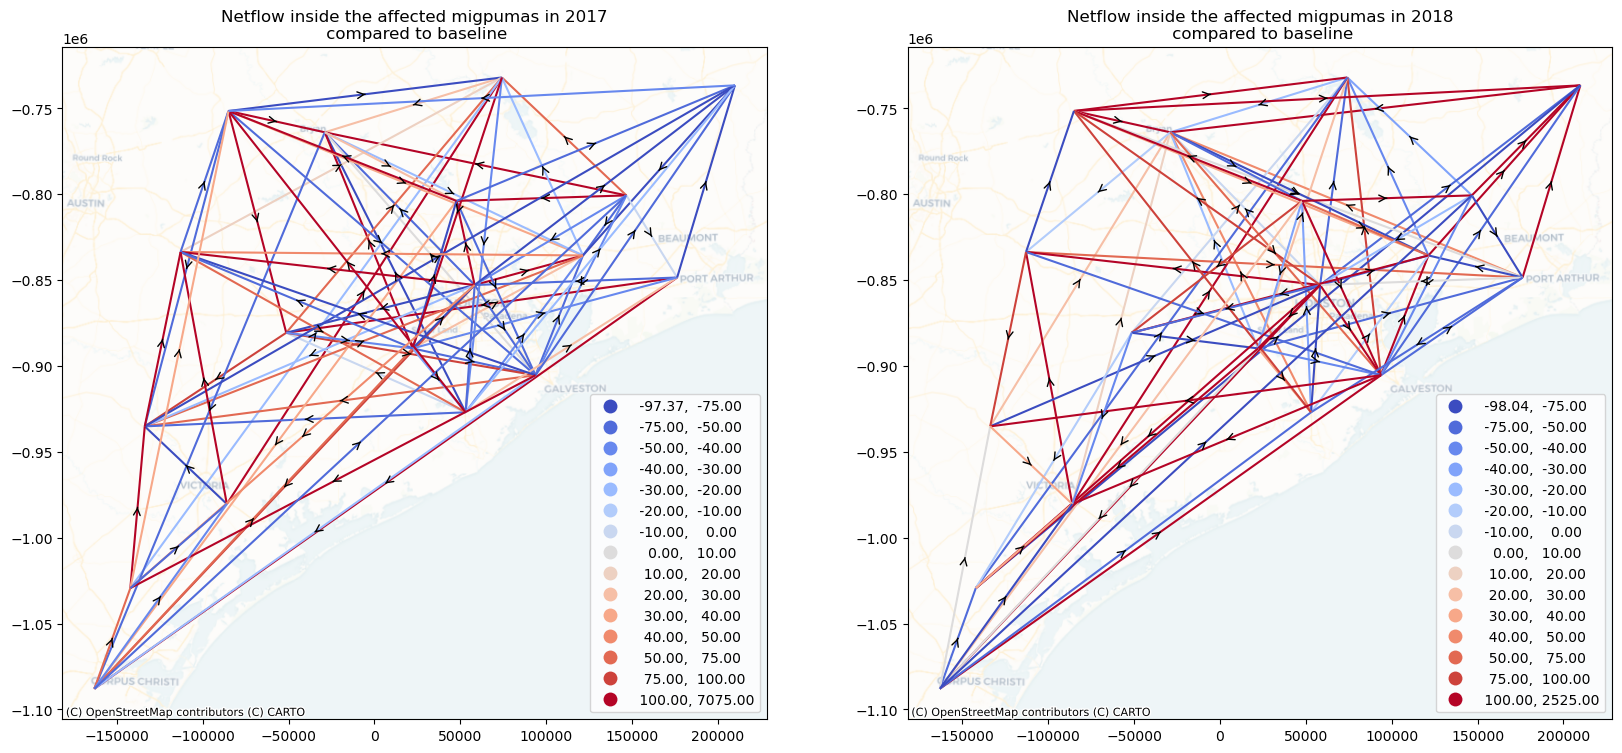

In [207]:
fig, axes = plt.subplots(1,2,figsize=(20,15))
for i in range(len(gdf_local_prior_in)):
    x0 = gdf_local_prior_in[i:i+1]["x_o"]
    x1 = gdf_local_prior_in[i:i+1]["x_d"]
    y0 = gdf_local_prior_in[i:i+1]["y_o"]
    y1 = gdf_local_prior_in[i:i+1]["y_d"]
    xpos = (x0+x1)/2
    ypos = (y0+y1)/2
    xdir = x1-x0
    ydir = y1-y0
    for X,Y,dX,dY in zip(xpos, ypos, xdir, ydir):
        axes[0].annotate("", xytext=(X,Y),xy=(X+0.001*dX,Y+0.001*dY), 
        arrowprops=dict(arrowstyle="->", color='k'), size = 12)
for i in range(len(gdf_local_prior_post1)):
    x0 = gdf_local_prior_post1[i:i+1]["x_o"]
    x1 = gdf_local_prior_post1[i:i+1]["x_d"]
    y0 = gdf_local_prior_post1[i:i+1]["y_o"]
    y1 = gdf_local_prior_post1[i:i+1]["y_d"]
    xpos = (x0+x1)/2
    ypos = (y0+y1)/2
    xdir = x1-x0
    ydir = y1-y0
    for X,Y,dX,dY in zip(xpos, ypos, xdir, ydir):
        axes[1].annotate("", xytext=(X,Y),xy=(X+0.001*dX,Y+0.001*dY), 
        arrowprops=dict(arrowstyle="->", color='k'), size = 12)
gdf_local_prior_in.plot(column='cr_prior_in',
     cmap='coolwarm',
     scheme='userdefined',classification_kwds={'bins':[ -75, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 75, 100]},
     legend=True,
     alpha = 1,
     legend_kwds={'loc': 'lower right'},
     ax=axes[0])
cx.add_basemap(ax=axes[0],source=cx.providers.CartoDB.Voyager,crs=gdf_od.crs,alpha = 0.4)
axes[0].set_title("Netflow inside the affected migpumas in 2017\n compared to baseline")
gdf_local_prior_post1.plot(column='cr_prior_post1',
     cmap='coolwarm',
     scheme='userdefined',classification_kwds={'bins':[ -75, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 75, 100]},
     alpha = 1,
     legend=True,
     legend_kwds={'loc': 'lower right'},
     ax=axes[1])
cx.add_basemap(ax=axes[1],source=cx.providers.CartoDB.Voyager,crs=gdf_od.crs,alpha = 0.4)
axes[1].set_title("Netflow inside the affected migpumas in 2018\n compared to baseline")

In [212]:
gdf_outflow_prior_in = gdf_outflow_prior_in.sort_values(by=['cr_prior_in'],ascending=False).reset_index(drop=True)
gdf_outflow_prior_in_50 = gdf_outflow_prior_in[0:100]
gdf_outflow_prior_post1 = gdf_outflow_prior_post1.sort_values(by=['cr_prior_post1'],ascending=False).reset_index(drop=True)
gdf_outflow_prior_post1_50 = gdf_outflow_prior_post1[0:100]

In [551]:
df_flow_in_texas_outflow_prior_in_dest = df_flow_in_texas_outflow_prior_in.groupby("MIGPUMA_D_2017").agg({"net_pop_Prior":"sum","net_pop_2017":"sum"}).reset_index()
df_flow_in_texas_outflow_prior_in_dest["cr_prior_in"] = (df_flow_in_texas_outflow_prior_in_dest["net_pop_2017"] - df_flow_in_texas_outflow_prior_in_dest["net_pop_Prior"]) / df_flow_in_texas_outflow_prior_in_dest["net_pop_Prior"]*100

df_flow_in_texas_outflow_prior_post1_dest = df_flow_in_texas_outflow_prior_post1.groupby("MIGPUMA_D_2018").agg({"net_pop_Prior":"sum","net_pop_2018":"sum"}).reset_index()
df_flow_in_texas_outflow_prior_post1_dest["cr_prior_post1"] = (df_flow_in_texas_outflow_prior_post1_dest["net_pop_2018"] - df_flow_in_texas_outflow_prior_post1_dest["net_pop_Prior"]) / df_flow_in_texas_outflow_prior_post1_dest["net_pop_Prior"]*100

In [553]:
gdf_flow_in_texas_outflow_prior_in_dest    = pd.merge(df_flow_in_texas_outflow_prior_in_dest,migpuma,left_on="MIGPUMA_D_2017",right_on="MIGPUMA2")
gdf_flow_in_texas_outflow_prior_in_dest    = gpd.GeoDataFrame(gdf_flow_in_texas_outflow_prior_in_dest,geometry="geometry")
gdf_flow_in_texas_outflow_prior_post1_dest = pd.merge(df_flow_in_texas_outflow_prior_post1_dest,migpuma,left_on="MIGPUMA_D_2018",right_on="MIGPUMA2")
gdf_flow_in_texas_outflow_prior_post1_dest    = gpd.GeoDataFrame(gdf_flow_in_texas_outflow_prior_post1_dest,geometry="geometry")

Text(0.5, 1.0, 'Netflow from the affected migpumas to others in 2018\n compared to baseline')

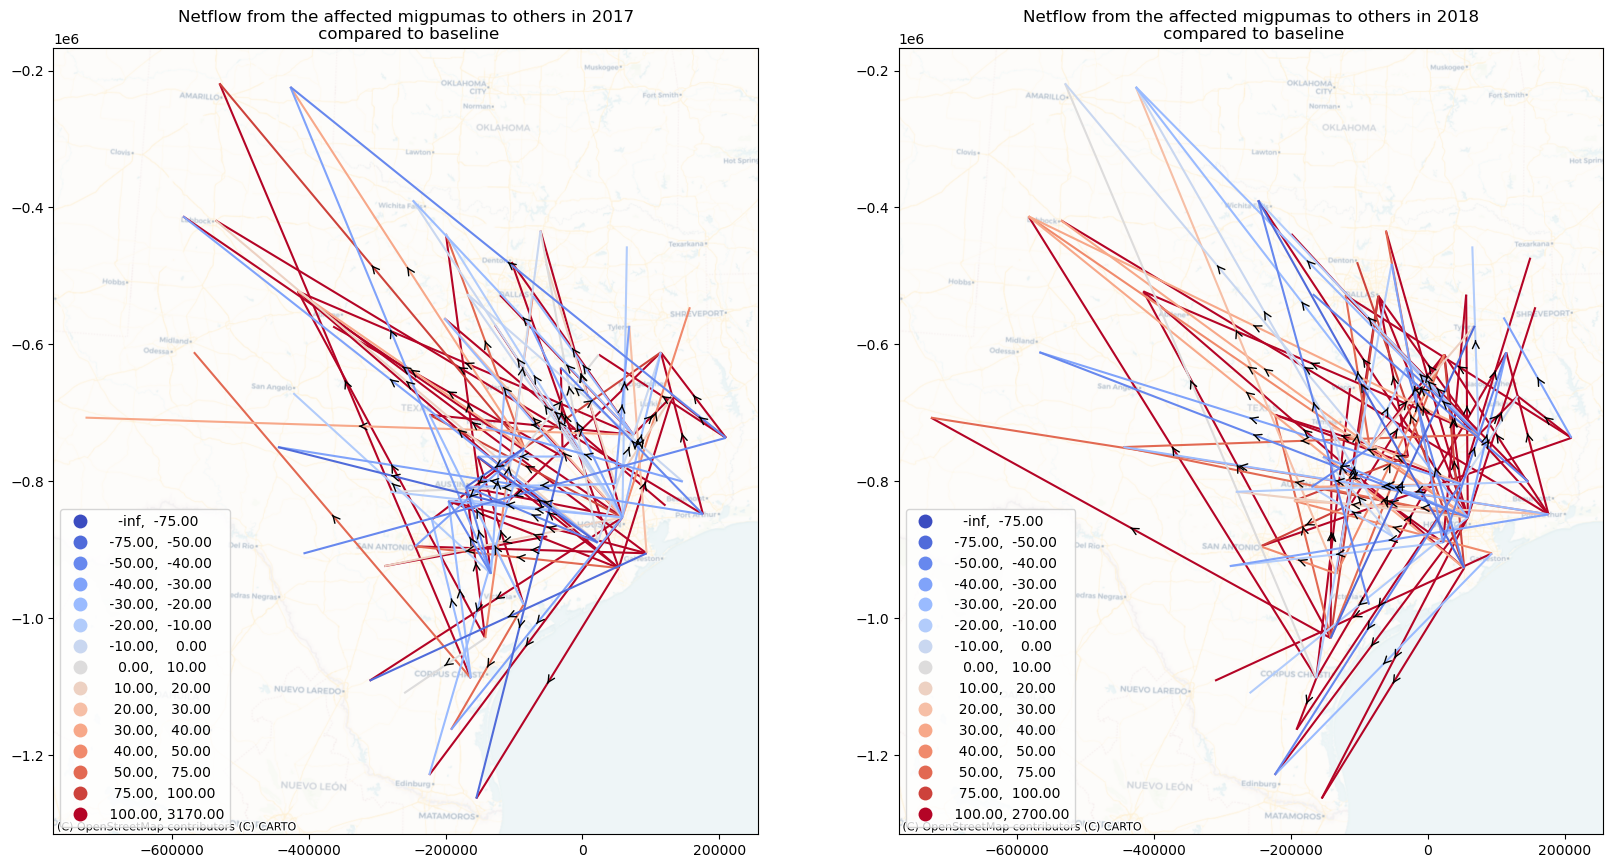

In [214]:
fig, axes = plt.subplots(1,2,figsize=(20,15))
for i in range(len(gdf_outflow_prior_in_50)):
    x0 = gdf_outflow_prior_in_50[i:i+1]["x_o"]
    x1 = gdf_outflow_prior_in_50[i:i+1]["x_d"]
    y0 = gdf_outflow_prior_in_50[i:i+1]["y_o"]
    y1 = gdf_outflow_prior_in_50[i:i+1]["y_d"]
    xpos = (x0+x1)/2
    ypos = (y0+y1)/2
    xdir = x1-x0
    ydir = y1-y0
    for X,Y,dX,dY in zip(xpos, ypos, xdir, ydir):
        axes[0].annotate("", xytext=(X,Y),xy=(X+0.001*dX,Y+0.001*dY), 
        arrowprops=dict(arrowstyle="->", color='k'), size = 12)
for i in range(len(gdf_outflow_prior_post1_50)):
    x0 = gdf_outflow_prior_post1_50[i:i+1]["x_o"]
    x1 = gdf_outflow_prior_post1_50[i:i+1]["x_d"]
    y0 = gdf_outflow_prior_post1_50[i:i+1]["y_o"]
    y1 = gdf_outflow_prior_post1_50[i:i+1]["y_d"]
    xpos = (x0+x1)/2
    ypos = (y0+y1)/2
    xdir = x1-x0
    ydir = y1-y0
    for X,Y,dX,dY in zip(xpos, ypos, xdir, ydir):
        axes[1].annotate("", xytext=(X,Y),xy=(X+0.001*dX,Y+0.001*dY), 
        arrowprops=dict(arrowstyle="->", color='k'), size = 12)
gdf_outflow_prior_in_50.plot(column='cr_prior_in',
     cmap='coolwarm',
     scheme='userdefined',classification_kwds={'bins':[ -75, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 75, 100]},
     legend=True,
     alpha = 1,
     legend_kwds={'loc': 'lower left'},
     ax=axes[0])
cx.add_basemap(ax=axes[0],source=cx.providers.CartoDB.Voyager,crs=gdf_od.crs,alpha = 0.4)
axes[0].set_title("Netflow from the affected migpumas to others in 2017\n compared to baseline")
gdf_outflow_prior_post1_50.plot(column='cr_prior_post1',
     cmap='coolwarm',
     scheme='userdefined',classification_kwds={'bins':[ -75, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 75, 100]},
     alpha = 1,
     legend=True,
     legend_kwds={'loc': 'lower left'},
     ax=axes[1])
cx.add_basemap(ax=axes[1],source=cx.providers.CartoDB.Voyager,crs=gdf_od.crs,alpha = 0.4)
axes[1].set_title("Netflow from the affected migpumas to others in 2018\n compared to baseline")

Destination maps from affected migpumas to other migpumas inside Texas

Text(0.5, 1.0, 'Ratio changes of outflows in 2018')

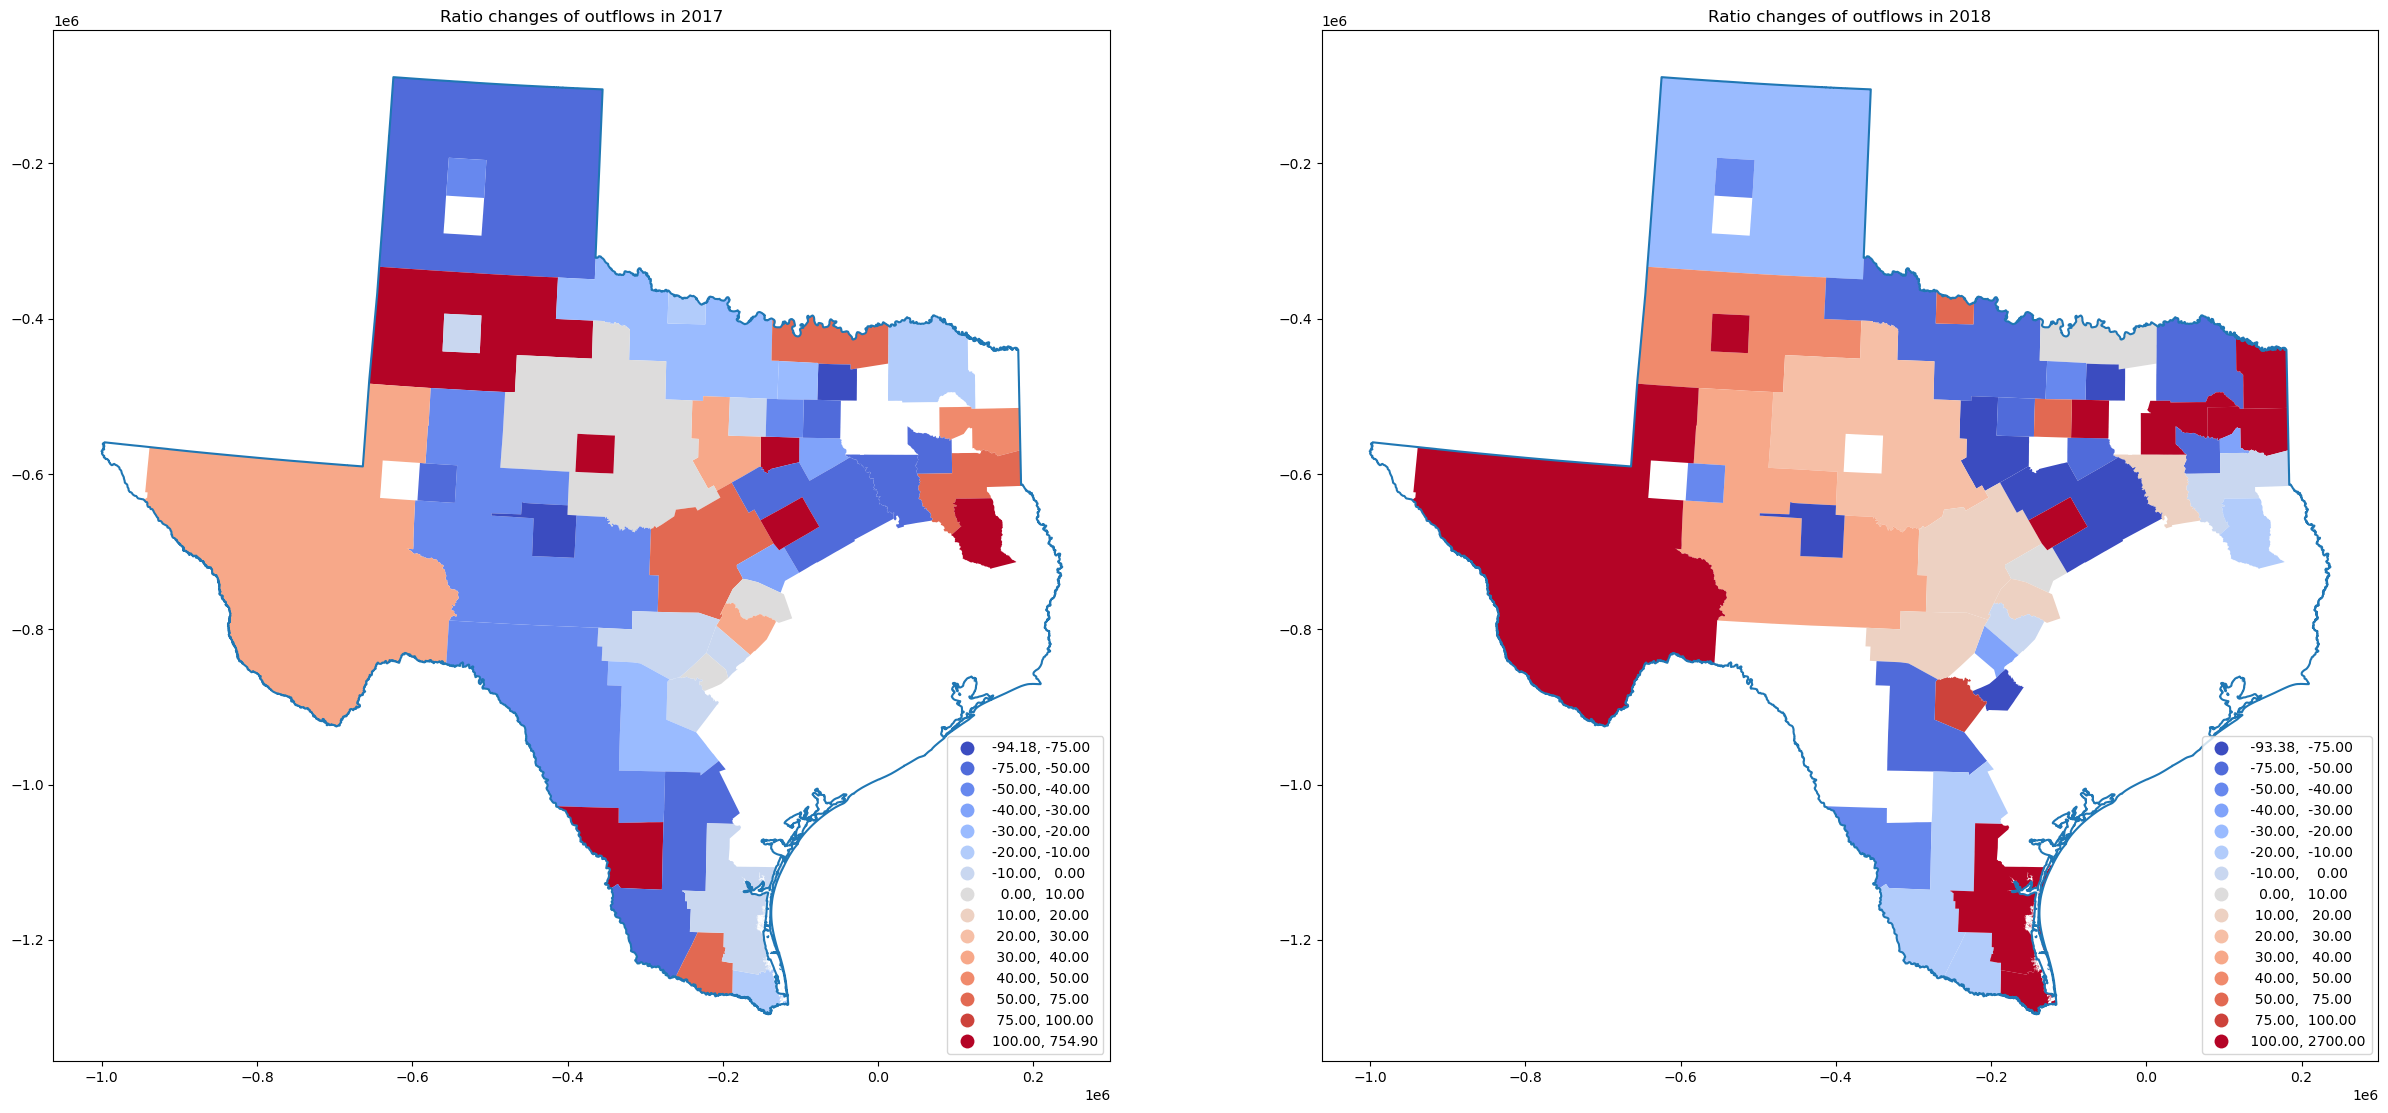

In [562]:
fig, axes = plt.subplots(1,2, figsize=(30, 20))
gdf_flow_in_texas_outflow_prior_in_dest.plot(column="cr_prior_in",cmap="coolwarm",
                         scheme='userdefined',classification_kwds={'bins':[ -75, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 75, 100]},
                         legend=True,ax=axes[0],legend_kwds={'loc': 'lower right'})
state_TX.boundary.plot(ax=axes[0])
axes[0].set_title("Ratio changes of outflows in 2017")
gdf_flow_in_texas_outflow_prior_post1_dest.plot(column="cr_prior_post1",cmap="coolwarm",
                         scheme='userdefined',classification_kwds={'bins':[ -75, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 75, 100]},
                         legend=True,ax=axes[1],legend_kwds={'loc': 'lower right'})
state_TX.boundary.plot(ax=axes[1])
axes[1].set_title("Ratio changes of outflows in 2018")

Netflows from other migpumas to migpumas inside Texas

In [678]:
gdf_other_prior_in = gdf_other_prior_in.sort_values(by=['cr_prior_in'],ascending=False).reset_index(drop=True)
# gdf_other_prior_in_50 = gdf_other_prior_in[0:150]
gdf_other_prior_in_50 = gdf_other_prior_in
gdf_other_prior_post1 = gdf_other_prior_post1.sort_values(by=['cr_prior_post1'],ascending=False).reset_index(drop=True)
# gdf_other_prior_post1_50 = gdf_other_prior_post1[0:150]
gdf_other_prior_post1_50 = gdf_other_prior_post1

Text(0.5, 1.0, 'Netflow in other migpumas in 2018\n compared to baseline')

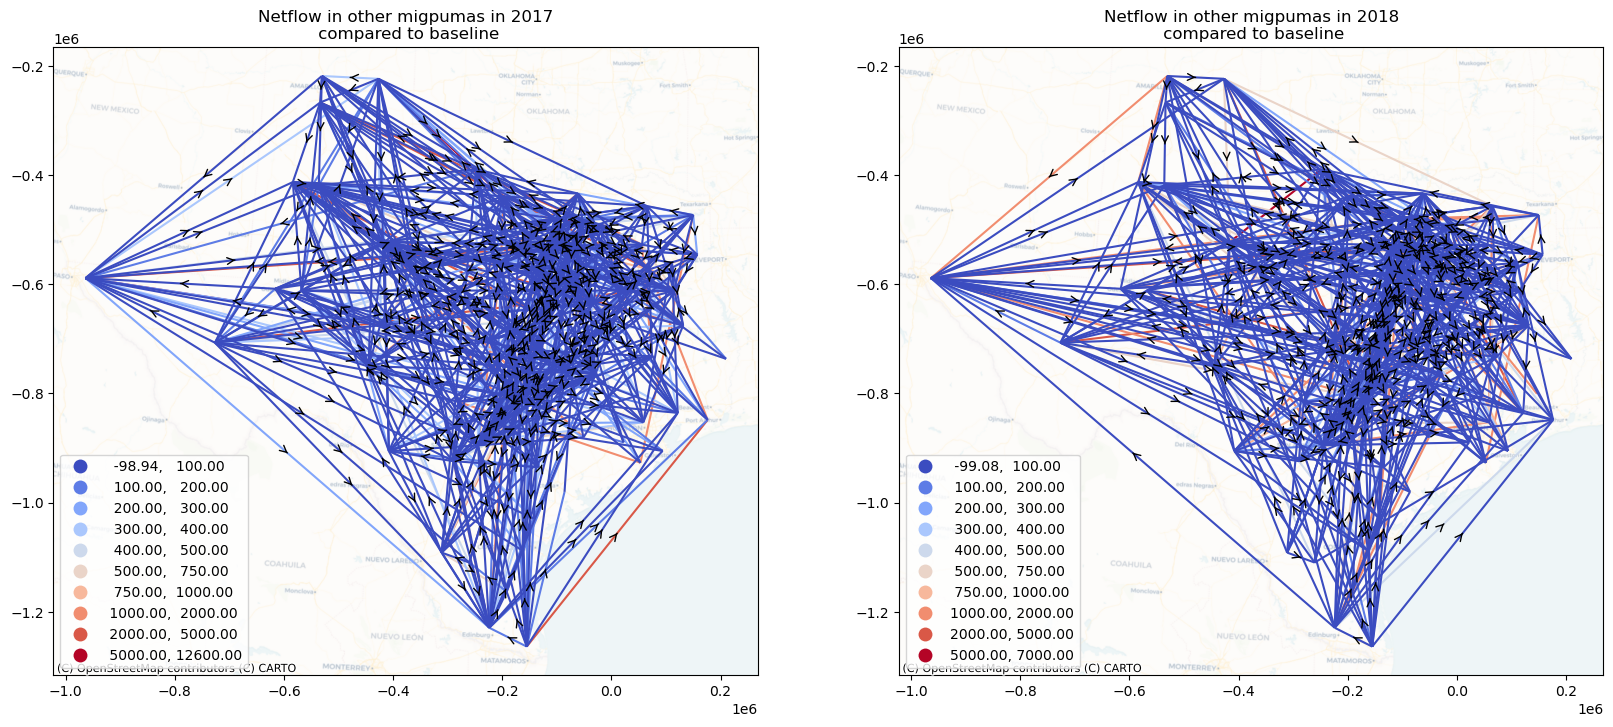

In [680]:
fig, axes = plt.subplots(1,2,figsize=(20,15))
for i in range(len(gdf_other_prior_in_50)):
    x0 = gdf_other_prior_in_50[i:i+1]["x_o"]
    x1 = gdf_other_prior_in_50[i:i+1]["x_d"]
    y0 = gdf_other_prior_in_50[i:i+1]["y_o"]
    y1 = gdf_other_prior_in_50[i:i+1]["y_d"]
    xpos = (x0+x1)/2
    ypos = (y0+y1)/2
    xdir = x1-x0
    ydir = y1-y0
    for X,Y,dX,dY in zip(xpos, ypos, xdir, ydir):
        axes[0].annotate("", xytext=(X,Y),xy=(X+0.001*dX,Y+0.001*dY), 
        arrowprops=dict(arrowstyle="->", color='k'), size = 12)
for i in range(len(gdf_other_prior_post1_50)):
    x0 = gdf_other_prior_post1_50[i:i+1]["x_o"]
    x1 = gdf_other_prior_post1_50[i:i+1]["x_d"]
    y0 = gdf_other_prior_post1_50[i:i+1]["y_o"]
    y1 = gdf_other_prior_post1_50[i:i+1]["y_d"]
    xpos = (x0+x1)/2
    ypos = (y0+y1)/2
    xdir = x1-x0
    ydir = y1-y0
    for X,Y,dX,dY in zip(xpos, ypos, xdir, ydir):
        axes[1].annotate("", xytext=(X,Y),xy=(X+0.001*dX,Y+0.001*dY), 
        arrowprops=dict(arrowstyle="->", color='k'), size = 12)
gdf_other_prior_in_50.plot(column='cr_prior_in',
     cmap='coolwarm',
#      cmap="YlOrRd",
#      scheme="quantiles",         
     scheme='userdefined',classification_kwds={'bins':[ 100,200,300,400,500,750,1000,2000,5000]},
     legend=True,
     alpha = 1,
     legend_kwds={'loc': 'lower left'},
     ax=axes[0])
cx.add_basemap(ax=axes[0],source=cx.providers.CartoDB.Voyager,crs=gdf_od.crs,alpha = 0.4)
axes[0].set_title("Netflow in other migpumas in 2017\n compared to baseline")
gdf_other_prior_post1_50.plot(column='cr_prior_post1',
     cmap='coolwarm',
#      cmap="YlOrRd",                         
#      scheme="quantiles",
#      scheme='userdefined',classification_kwds={'bins':[ 100,200,300,400,500,750,1000,2000,5000]},
     alpha = 1,
     legend=True,
     legend_kwds={'loc': 'lower left'},
     ax=axes[1])
cx.add_basemap(ax=axes[1],source=cx.providers.CartoDB.Voyager,crs=gdf_od.crs,alpha = 0.4)
axes[1].set_title("Netflow in other migpumas in 2018\n compared to baseline")

In [564]:
df_flow_in_texas_other_prior_in_dest = df_flow_in_texas_other_prior_in.groupby("MIGPUMA_D_2017").agg({"net_pop_Prior":"sum","net_pop_2017":"sum"}).reset_index()
df_flow_in_texas_other_prior_in_dest["cr_prior_in"] = (df_flow_in_texas_other_prior_in_dest["net_pop_2017"] - df_flow_in_texas_other_prior_in_dest["net_pop_Prior"]) / df_flow_in_texas_other_prior_in_dest["net_pop_Prior"]*100

df_flow_in_texas_other_prior_post1_dest = df_flow_in_texas_other_prior_post1.groupby("MIGPUMA_D_2018").agg({"net_pop_Prior":"sum","net_pop_2018":"sum"}).reset_index()
df_flow_in_texas_other_prior_post1_dest["cr_prior_post1"] = (df_flow_in_texas_other_prior_post1_dest["net_pop_2018"] - df_flow_in_texas_other_prior_post1_dest["net_pop_Prior"]) / df_flow_in_texas_other_prior_post1_dest["net_pop_Prior"]*100

In [565]:
gdf_flow_in_texas_other_prior_in_dest    = pd.merge(df_flow_in_texas_other_prior_in_dest,migpuma,left_on="MIGPUMA_D_2017",right_on="MIGPUMA2")
gdf_flow_in_texas_other_prior_in_dest    = gpd.GeoDataFrame(gdf_flow_in_texas_other_prior_in_dest,geometry="geometry")
gdf_flow_in_texas_other_prior_post1_dest = pd.merge(df_flow_in_texas_other_prior_post1_dest,migpuma,left_on="MIGPUMA_D_2018",right_on="MIGPUMA2")
gdf_flow_in_texas_other_prior_post1_dest = gpd.GeoDataFrame(gdf_flow_in_texas_other_prior_post1_dest,geometry="geometry")

Text(0.5, 1.0, 'Ratio changes of outflows in 2018')

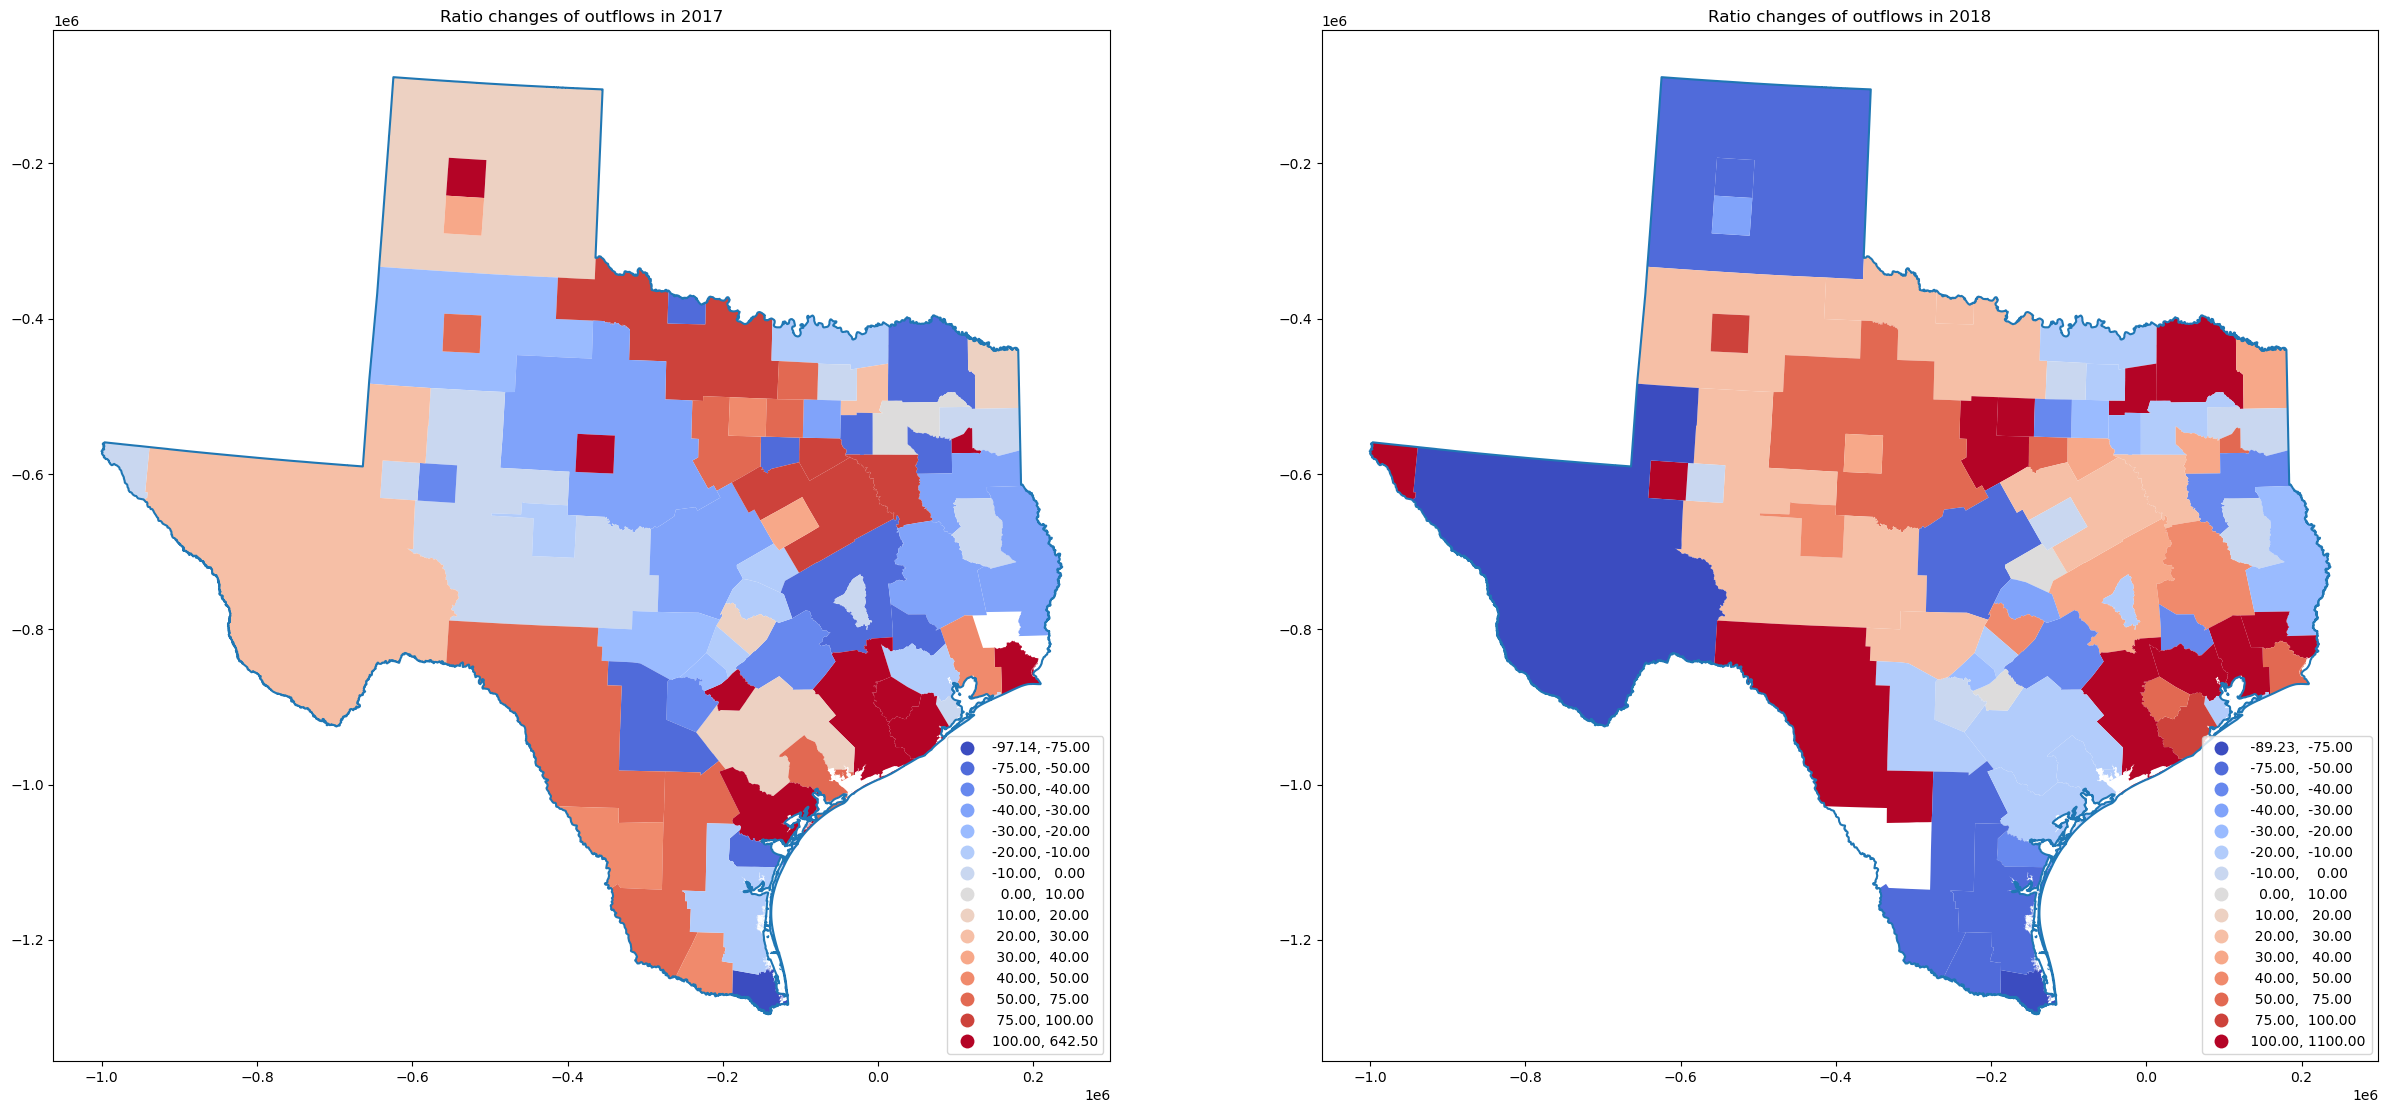

In [566]:
fig, axes = plt.subplots(1,2, figsize=(30, 20))
gdf_flow_in_texas_other_prior_in_dest.plot(column="cr_prior_in",cmap="coolwarm",
                         scheme='userdefined',classification_kwds={'bins':[ -75, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 75, 100]},
                         legend=True,ax=axes[0],legend_kwds={'loc': 'lower right'})
state_TX.boundary.plot(ax=axes[0])
axes[0].set_title("Ratio changes of outflows in 2017")
gdf_flow_in_texas_other_prior_post1_dest.plot(column="cr_prior_post1",cmap="coolwarm",
                         scheme='userdefined',classification_kwds={'bins':[ -75, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 75, 100]},
                         legend=True,ax=axes[1],legend_kwds={'loc': 'lower right'})
state_TX.boundary.plot(ax=axes[1])
axes[1].set_title("Ratio changes of outflows in 2018")

### Inter-state migration associated with disaster event map <a id = "interstate"></a>
Whether the previous hurricane experences affect the further decision.

In [236]:
county_used_para = county[["NAME","FIPS","POPULATION","geometry"]]

In [248]:
SHELDUS_select["County FIPS"] = SHELDUS_select.apply(lambda x: x["County FIPS"][1:-1], axis = 1)

In [411]:
SHELDUS_select

State Name County Name County FIPS    Hazard  Year  Month  \
0          ALABAMA     Autauga       01001  Flooding  1976      3   
1          ALABAMA     Autauga       01001  Flooding  1979      3   
2          ALABAMA     Autauga       01001  Flooding  1982      6   
3          ALABAMA     Autauga       01001  Flooding  1979      2   
4          ALABAMA     Autauga       01001  Flooding  1979      4   
...            ...         ...         ...       ...   ...    ...   
91236  PUERTO RICO    Toa Alta       72135  Flooding  2005      9   
91237  PUERTO RICO    Toa Alta       72135  Flooding  2006      8   
91238  PUERTO RICO    Toa Alta       72135  Flooding  2007      9   
91239  PUERTO RICO    Toa Alta       72135  Flooding  2007     12   
91240  PUERTO RICO     Vieques       72147  Flooding  2003     11   

            CropDmg  CropDmg(ADJ 2020)  CropDmgPerCapita(ADJ 2020)  \
0      8.333300e+02       3.838880e+03                     0.12839   
1      0.000000e+00       0.000000e+00                     0.00000   
2      0.000000e+00       0.000000e+00                     0.00000   
3      0.000000e+00       0.000000e+00                     0.00000   
4      7.246377e+03       2.616278e+04                     0.81504   
...             ...                ...                         ...   
91236  0.000000e+00       0.000000e+00                     0.00000   
91237  0.000000e+00       0.000000e+00                     0.00000   
91238  0.000000e+00       0.000000e+00                     0.00000   
91239  0.000000e+00       0.000000e+00                     0.00000   
91240  3.000000e+06       4.273690e+06                   466.25461   

       PropertyDmg  PropertyDmg(ADJ 2020)  PropertyDmgPerCapita(ADJ 2020)  \
0      83333.33000           383889.32000                        12.83911   
1      24875.62333            89812.52667                         2.79790   
2        131.58000              357.40500                         0.01116   
3         37.31500              134.72500                         0.00420   
4      72463.76667           261627.77333                         8.15040   
...            ...                    ...                             ...   
91236   1000.00000             1342.14000                         0.01942   
91237  18750.00000            24378.69000                         0.34757   
91238    250.00000              316.05000                         0.00444   
91239    875.00000             1106.16000                         0.01554   
91240      0.00000                0.00000                         0.00000   

       Injuries  InjuriesPerCapita  Fatalities  FatalitiesPerCapita  \
0       0.00000                0.0        0.00                  0.0   
1       0.00000                0.0        0.04                  0.0   
2       0.00000                0.0        0.00                  0.0   
3       0.00000                0.0        0.00                  0.0   
4       0.04333                0.0        0.10                  0.0   
...         ...                ...         ...                  ...   
91236   0.00000                0.0        0.00                  0.0   
91237   0.00000                0.0        0.00                  0.0   
91238   0.00000                0.0        0.00                  0.0   
91239   0.00000                0.0        0.00                  0.0   
91240   0.00000                0.0        0.00                  0.0   

       Duration_Days  Fatalities_Duration  Injuries_Duration  \
0                2.0                  0.0                0.0   
1                3.0                  3.0                0.0   
2                1.0                  0.0                0.0   
3                1.0                  0.0                0.0   
4                2.0                  2.0                2.0   
...              ...                  ...                ...   
91236            1.0                  0.0                0.0   
91237            1.0                  0.0       

In [250]:
SHELDUS_select_merge = pd.merge(SHELDUS_select,county_used_para,left_on="County FIPS",right_on="FIPS")

In [415]:
gdf_SHELDUS_select_merge = gpd.GeoDataFrame(SHELDUS_select_merge,geometry="geometry").to_crs("ESRI:102003")

In [416]:
year_list = []
for i in range(1960,2015):
    year_list.append(i)

In [417]:
gdf_SHELDUS_select_merge = gdf_SHELDUS_select_merge.loc[gdf_SHELDUS_select_merge["Year"].isin(year_list)].reset_index()

In [418]:
gdf_SHELDUS_select_count = gdf_SHELDUS_select_merge.groupby(["County FIPS","Hazard"]).sum("Records").reset_index()

In [420]:
gdf_SHELDUS_select_count = gdf_SHELDUS_select_count[["County FIPS","Hazard","Records"]]
gdf_SHELDUS_select_count = gdf_SHELDUS_select_count.rename(columns={"Records":"count"})
gdf_SHELDUS_select_count_merge = pd.merge(gdf_SHELDUS_select_count,county_used_para,left_on="County FIPS",right_on="FIPS")
gdf_SHELDUS_select_count_merge = gpd.GeoDataFrame(gdf_SHELDUS_select_count_merge,geometry="geometry").to_crs("ESRI:102003")

In [421]:
gdf_SHELDUS_select_count_merge_flood = gdf_SHELDUS_select_count_merge[gdf_SHELDUS_select_count_merge["Hazard"]=="Flooding"].reset_index(drop=True)
gdf_SHELDUS_select_count_merge_hurricane = gdf_SHELDUS_select_count_merge[gdf_SHELDUS_select_count_merge["Hazard"]=="Hurricane/Tropical Storm"].reset_index(drop=True)

Text(0.5, 1.0, 'Flooding maps')

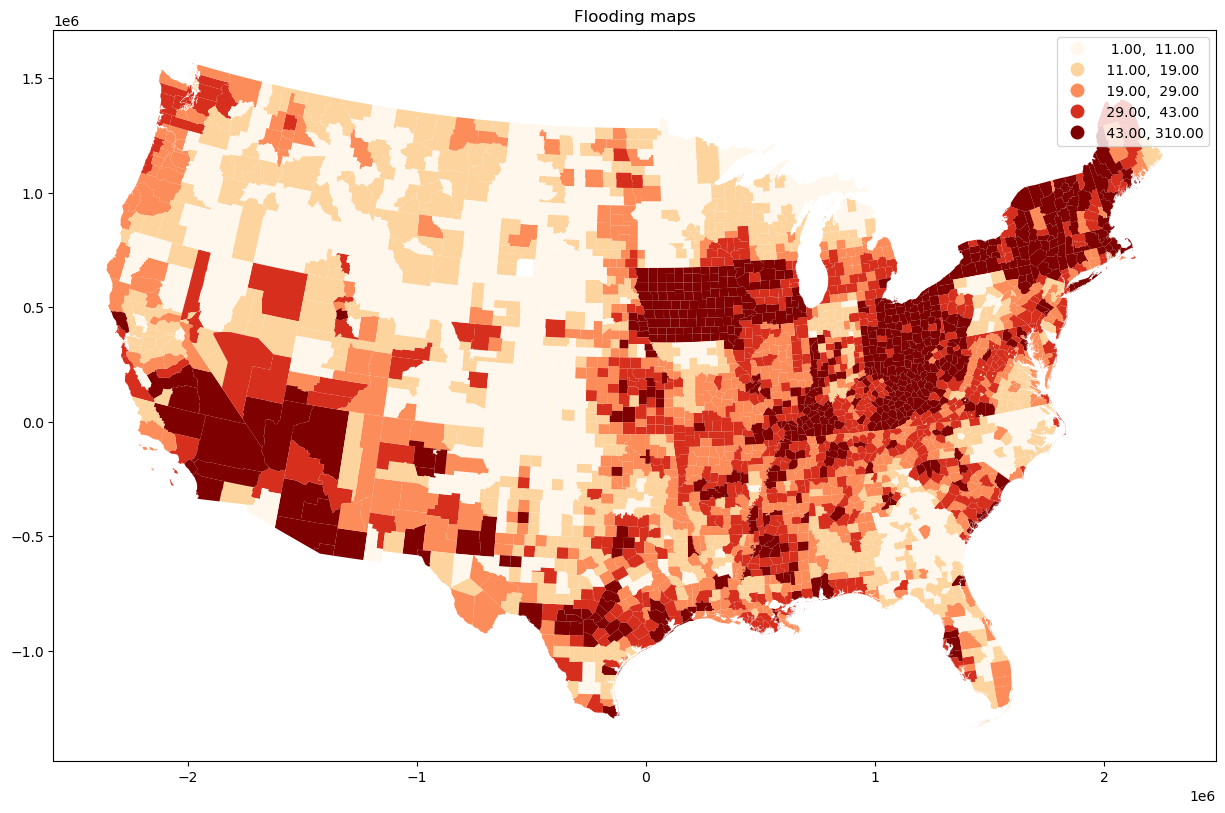

In [422]:
gdf_SHELDUS_select_count_merge_flood.plot("count",cmap="OrRd",scheme="quantiles",legend=True).set_title('Flooding maps')

Text(0.5, 1.0, 'Hurricane/Tropical Storm maps')

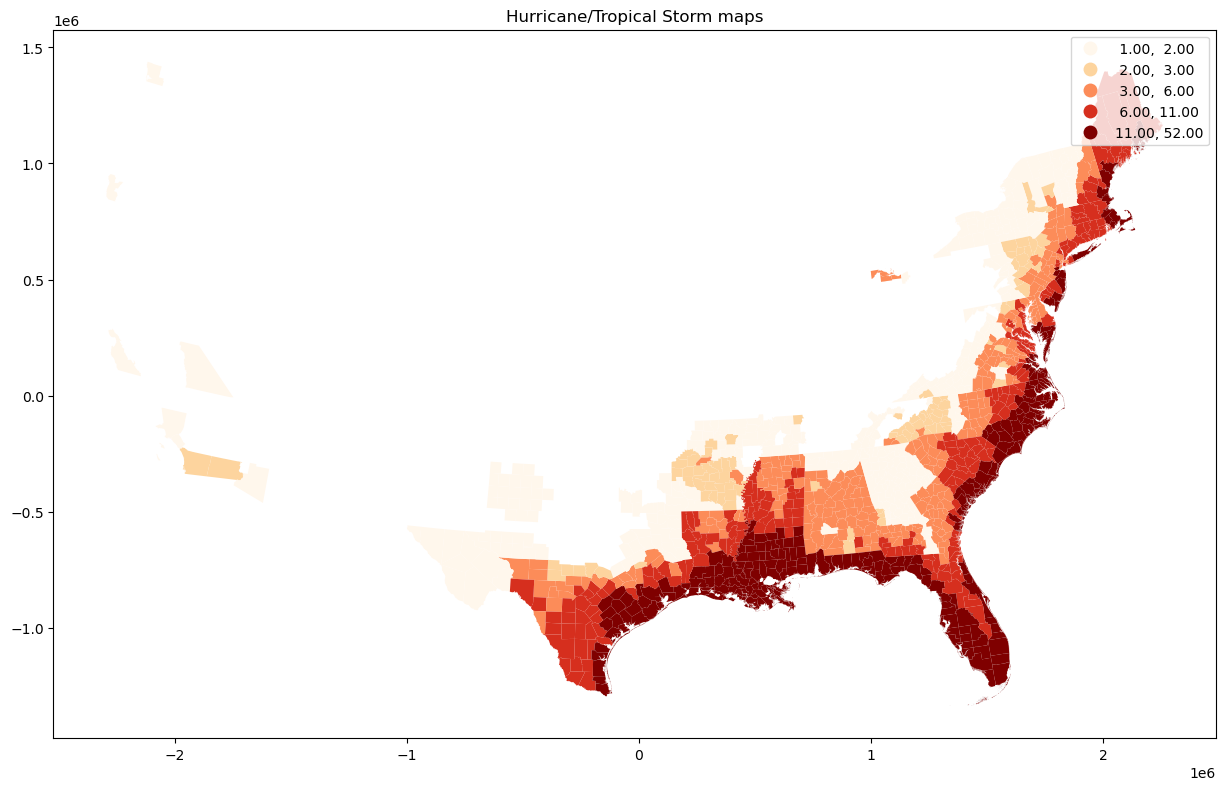

In [423]:
gdf_SHELDUS_select_count_merge_hurricane.plot("count",cmap="OrRd",scheme="quantiles",legend=True).set_title('Hurricane/Tropical Storm maps')

In [317]:
migpuma_otherstate = migpuma[migpuma["State"]!="Texas"]

In [320]:
migpuma_otherstate = list(migpuma_otherstate.MIGPUMA2.unique())

In [359]:
df_od_inter_state = df_od.loc[df_od["MIGPUMA_D"].isin(migpuma_otherstate)]

In [401]:
df_od_inter_state_group = df_od_inter_state.groupby("MIGPUMA_D").sum("PWGTP").reset_index()

In [403]:
df_od_inter_state_merge = pd.merge(df_od_inter_state_group,df_migpuma_county,left_on="MIGPUMA_D",right_on="MIGPUMA2")

In [424]:
SHELDUS_select_count_group = gdf_SHELDUS_select_count_merge.groupby(["County FIPS"]).sum("count").reset_index()

In [425]:
SHELDUS_select_count_group

County FIPS  count  POPULATION
0          01001     31      116448
1          01003     60      455320
2          01005     19       52652
3          01007     28       46132
4          01009     36      119940
...          ...    ...         ...
3102       56037      7       44774
3103       56039      7       23294
3104       56041      2       21555
3105       56043     13        8046
3106       56045      9        7063

[3107 rows x 3 columns]

In [426]:
df_od_inter_state_merge_county = pd.merge(df_od_inter_state_merge,SHELDUS_select_count_group,left_on="FIPS",right_on="County FIPS")

In [442]:
PWGTP_max = max(df_od_inter_state_merge_county.PWGTP)
PWGTP_min = min(df_od_inter_state_merge_county.PWGTP)

count_max = max(df_od_inter_state_merge_county["count"])
count_min = min(df_od_inter_state_merge_county["count"])

In [450]:
df_od_inter_state_merge_county["norm_PWGTP"] = df_od_inter_state_merge_county["PWGTP"].apply(lambda x: (int(x)-PWGTP_min)/(PWGTP_max-PWGTP_min))
df_od_inter_state_merge_county["norm_count"] = df_od_inter_state_merge_county["count"].apply(lambda x: (int(x)-count_min)/(count_max-count_min))

In [323]:
df_flow_inter_state_2015 = df_od_inter_state.loc[df_od_inter_state["year"].isin(["2015"])].reset_index(drop=True)
df_flow_inter_state_2016 = df_od_inter_state.loc[df_od_inter_state["year"].isin(["2016"])].reset_index(drop=True)
df_flow_inter_state_2017 = df_od_inter_state.loc[df_od_inter_state["year"].isin(["2017"])].reset_index(drop=True)
df_flow_inter_state_2018 = df_od_inter_state.loc[df_od_inter_state["year"].isin(["2018"])].reset_index(drop=True)
df_flow_inter_state_2019 = df_od_inter_state.loc[df_od_inter_state["year"].isin(["2019"])].reset_index(drop=True)

In [328]:
def uniqueName(df):
    name = str(df.year.unique()[0])
    df = df.rename(columns={"MIGPUMA_O": "MIGPUMA_O_"+name,
                            "year":"year_"+name,
                            "MIGPUMA_D":"MIGPUMA_D_"+name,
                            "PWGTP":"PWGTP_"+name})
    return df

In [329]:
df_flow_inter_state_2015 = uniqueName(df_flow_inter_state_2015)
df_flow_inter_state_2016 = uniqueName(df_flow_inter_state_2016)
df_flow_inter_state_2017 = uniqueName(df_flow_inter_state_2017)
df_flow_inter_state_2018 = uniqueName(df_flow_inter_state_2018)
df_flow_inter_state_2019 = uniqueName(df_flow_inter_state_2019)

In [475]:
df_flow_inter_state_2015_group = df_flow_inter_state_2015.groupby("MIGPUMA_D_2015").sum("PWGTP_2015").reset_index()
df_flow_inter_state_2016_group = df_flow_inter_state_2016.groupby("MIGPUMA_D_2016").sum("PWGTP_2016").reset_index()
df_flow_inter_state_2017_group = df_flow_inter_state_2017.groupby("MIGPUMA_D_2017").sum("PWGTP_2017").reset_index()
df_flow_inter_state_2018_group = df_flow_inter_state_2018.groupby("MIGPUMA_D_2018").sum("PWGTP_2018").reset_index()
df_flow_inter_state_2019_group = df_flow_inter_state_2019.groupby("MIGPUMA_D_2019").sum("PWGTP_2019").reset_index()

In [478]:
merge_flow_inter_15_16 = pd.merge(df_flow_inter_state_2015_group,df_flow_inter_state_2016_group,left_on="MIGPUMA_D_2015",
                         right_on="MIGPUMA_D_2016",how="outer")
listNum = []
merge_flow_inter_15_16 = merge_flow_inter_15_16.fillna(0)
for i in range(len(merge_flow_inter_15_16)):
    List = []
    List.append(int(merge_flow_inter_15_16[i:i+1]["PWGTP_2015"]))
    List.append(int(merge_flow_inter_15_16[i:i+1]["PWGTP_2016"]))
    number = 2 - int(List.count(0))
    listNum.append(number)
merge_flow_inter_15_16["countNum"] = listNum
merge_flow_inter_15_16["PWGTP_AVG"] = (merge_flow_inter_15_16["PWGTP_2015"]+merge_flow_inter_15_16["PWGTP_2016"])/merge_flow_inter_15_16["countNum"]

In [481]:
merge_flow_inter_prior_in    = pd.merge(merge_flow_inter_15_16,df_flow_inter_state_2017_group,left_on="MIGPUMA_D_2015",right_on="MIGPUMA_D_2017")
merge_flow_inter_prior_post1 = pd.merge(merge_flow_inter_15_16,df_flow_inter_state_2018_group,left_on="MIGPUMA_D_2015",right_on="MIGPUMA_D_2018")

merge_flow_inter_prior_in["cr_prior_in"] = (merge_flow_inter_prior_in["PWGTP_2017"] - merge_flow_inter_prior_in["PWGTP_AVG"]) / merge_flow_inter_prior_in["PWGTP_AVG"]*100
merge_flow_inter_prior_post1["cr_prior_post1"] = (merge_flow_inter_prior_post1["PWGTP_2018"] - merge_flow_inter_prior_post1["PWGTP_AVG"]) / merge_flow_inter_prior_post1["PWGTP_AVG"]*100


In [349]:
df_flow_inter_state_2015_county = pd.merge(df_flow_inter_state_2015,df_migpuma_county,left_on="MIGPUMA_D_2015",right_on="MIGPUMA2")
df_flow_inter_state_2016_county = pd.merge(df_flow_inter_state_2016,df_migpuma_county,left_on="MIGPUMA_D_2016",right_on="MIGPUMA2")
df_flow_inter_state_2017_county = pd.merge(df_flow_inter_state_2017,df_migpuma_county,left_on="MIGPUMA_D_2017",right_on="MIGPUMA2")
df_flow_inter_state_2018_county = pd.merge(df_flow_inter_state_2018,df_migpuma_county,left_on="MIGPUMA_D_2018",right_on="MIGPUMA2")
df_flow_inter_state_2019_county = pd.merge(df_flow_inter_state_2019,df_migpuma_county,left_on="MIGPUMA_D_2019",right_on="MIGPUMA2")

In [363]:
df_flow_inter_state_2015_county_group = df_flow_inter_state_2015_county.groupby(["MIGPUMA2","FIPS"]).sum("PWGTP_2015").reset_index()
df_flow_inter_state_2016_county_group = df_flow_inter_state_2016_county.groupby(["MIGPUMA2","FIPS"]).sum("PWGTP_2016").reset_index()
df_flow_inter_state_2017_county_group = df_flow_inter_state_2017_county.groupby(["MIGPUMA2","FIPS"]).sum("PWGTP_2017").reset_index()
df_flow_inter_state_2018_county_group = df_flow_inter_state_2018_county.groupby(["MIGPUMA2","FIPS"]).sum("PWGTP_2018").reset_index()

In [369]:
merge_flow_inter_15_16 = pd.merge(df_flow_inter_state_2015_county_group,df_flow_inter_state_2016_county_group,left_on="MIGPUMA2",
                         right_on="MIGPUMA2",how="outer")
listNum = []
merge_flow_inter_15_16 = merge_flow_inter_15_16.fillna(0)
for i in range(len(merge_flow_inter_15_16)):
    List = []
    List.append(int(merge_flow_inter_15_16[i:i+1]["PWGTP_2015"]))
    List.append(int(merge_flow_inter_15_16[i:i+1]["PWGTP_2016"]))
    number = 2 - int(List.count(0))
    listNum.append(number)
merge_flow_inter_15_16["countNum"] = listNum
merge_flow_inter_15_16["PWGTP_AVG"] = (merge_flow_inter_15_16["PWGTP_2015"]+merge_flow_inter_15_16["PWGTP_2016"])/merge_flow_inter_15_16["countNum"]

In [385]:
merge_flow_inter_prior_in    = pd.merge(merge_flow_inter_15_16,df_flow_inter_state_2017_county_group,left_on=["MIGPUMA2","FIPS_x"],right_on=["MIGPUMA2","FIPS"])
merge_flow_inter_prior_post1 = pd.merge(merge_flow_inter_15_16,df_flow_inter_state_2018_county_group,left_on=["MIGPUMA2","FIPS_x"],right_on=["MIGPUMA2","FIPS"])

merge_flow_inter_prior_in["cr_prior_in"] = (merge_flow_inter_prior_in["PWGTP_2017"] - merge_flow_inter_prior_in["PWGTP_AVG"]) / merge_flow_inter_prior_in["PWGTP_AVG"]*100
merge_flow_inter_prior_post1["cr_prior_post1"] = (merge_flow_inter_prior_post1["PWGTP_2018"] - merge_flow_inter_prior_post1["PWGTP_AVG"]) / merge_flow_inter_prior_post1["PWGTP_AVG"]*100


In [485]:
merge_flow_inter_prior_in_merge = pd.merge(merge_flow_inter_prior_in,migpuma,left_on="MIGPUMA_D_2015",right_on="MIGPUMA2")
merge_flow_inter_prior_post1_merge = pd.merge(merge_flow_inter_prior_post1,migpuma,left_on="MIGPUMA_D_2015",right_on="MIGPUMA2")

In [487]:
gdf_merge_flow_inter_prior_in_merge = gpd.GeoDataFrame(merge_flow_inter_prior_in_merge,geometry="geometry")
gdf_merge_flow_inter_prior_post1_merge = gpd.GeoDataFrame(merge_flow_inter_prior_post1_merge,geometry="geometry")

In [492]:
gdf_merge_flow_inter_prior_in_merge = gdf_merge_flow_inter_prior_in_merge.loc[~gdf_merge_flow_inter_prior_in_merge["State"].isin(["Alaska","Hawaii"])]
gdf_merge_flow_inter_prior_post1_merge = gdf_merge_flow_inter_prior_post1_merge.loc[~gdf_merge_flow_inter_prior_post1_merge["State"].isin(["Alaska","Hawaii"])]

Text(0.5, 1.0, 'Ratio changes of destinations in 2018')

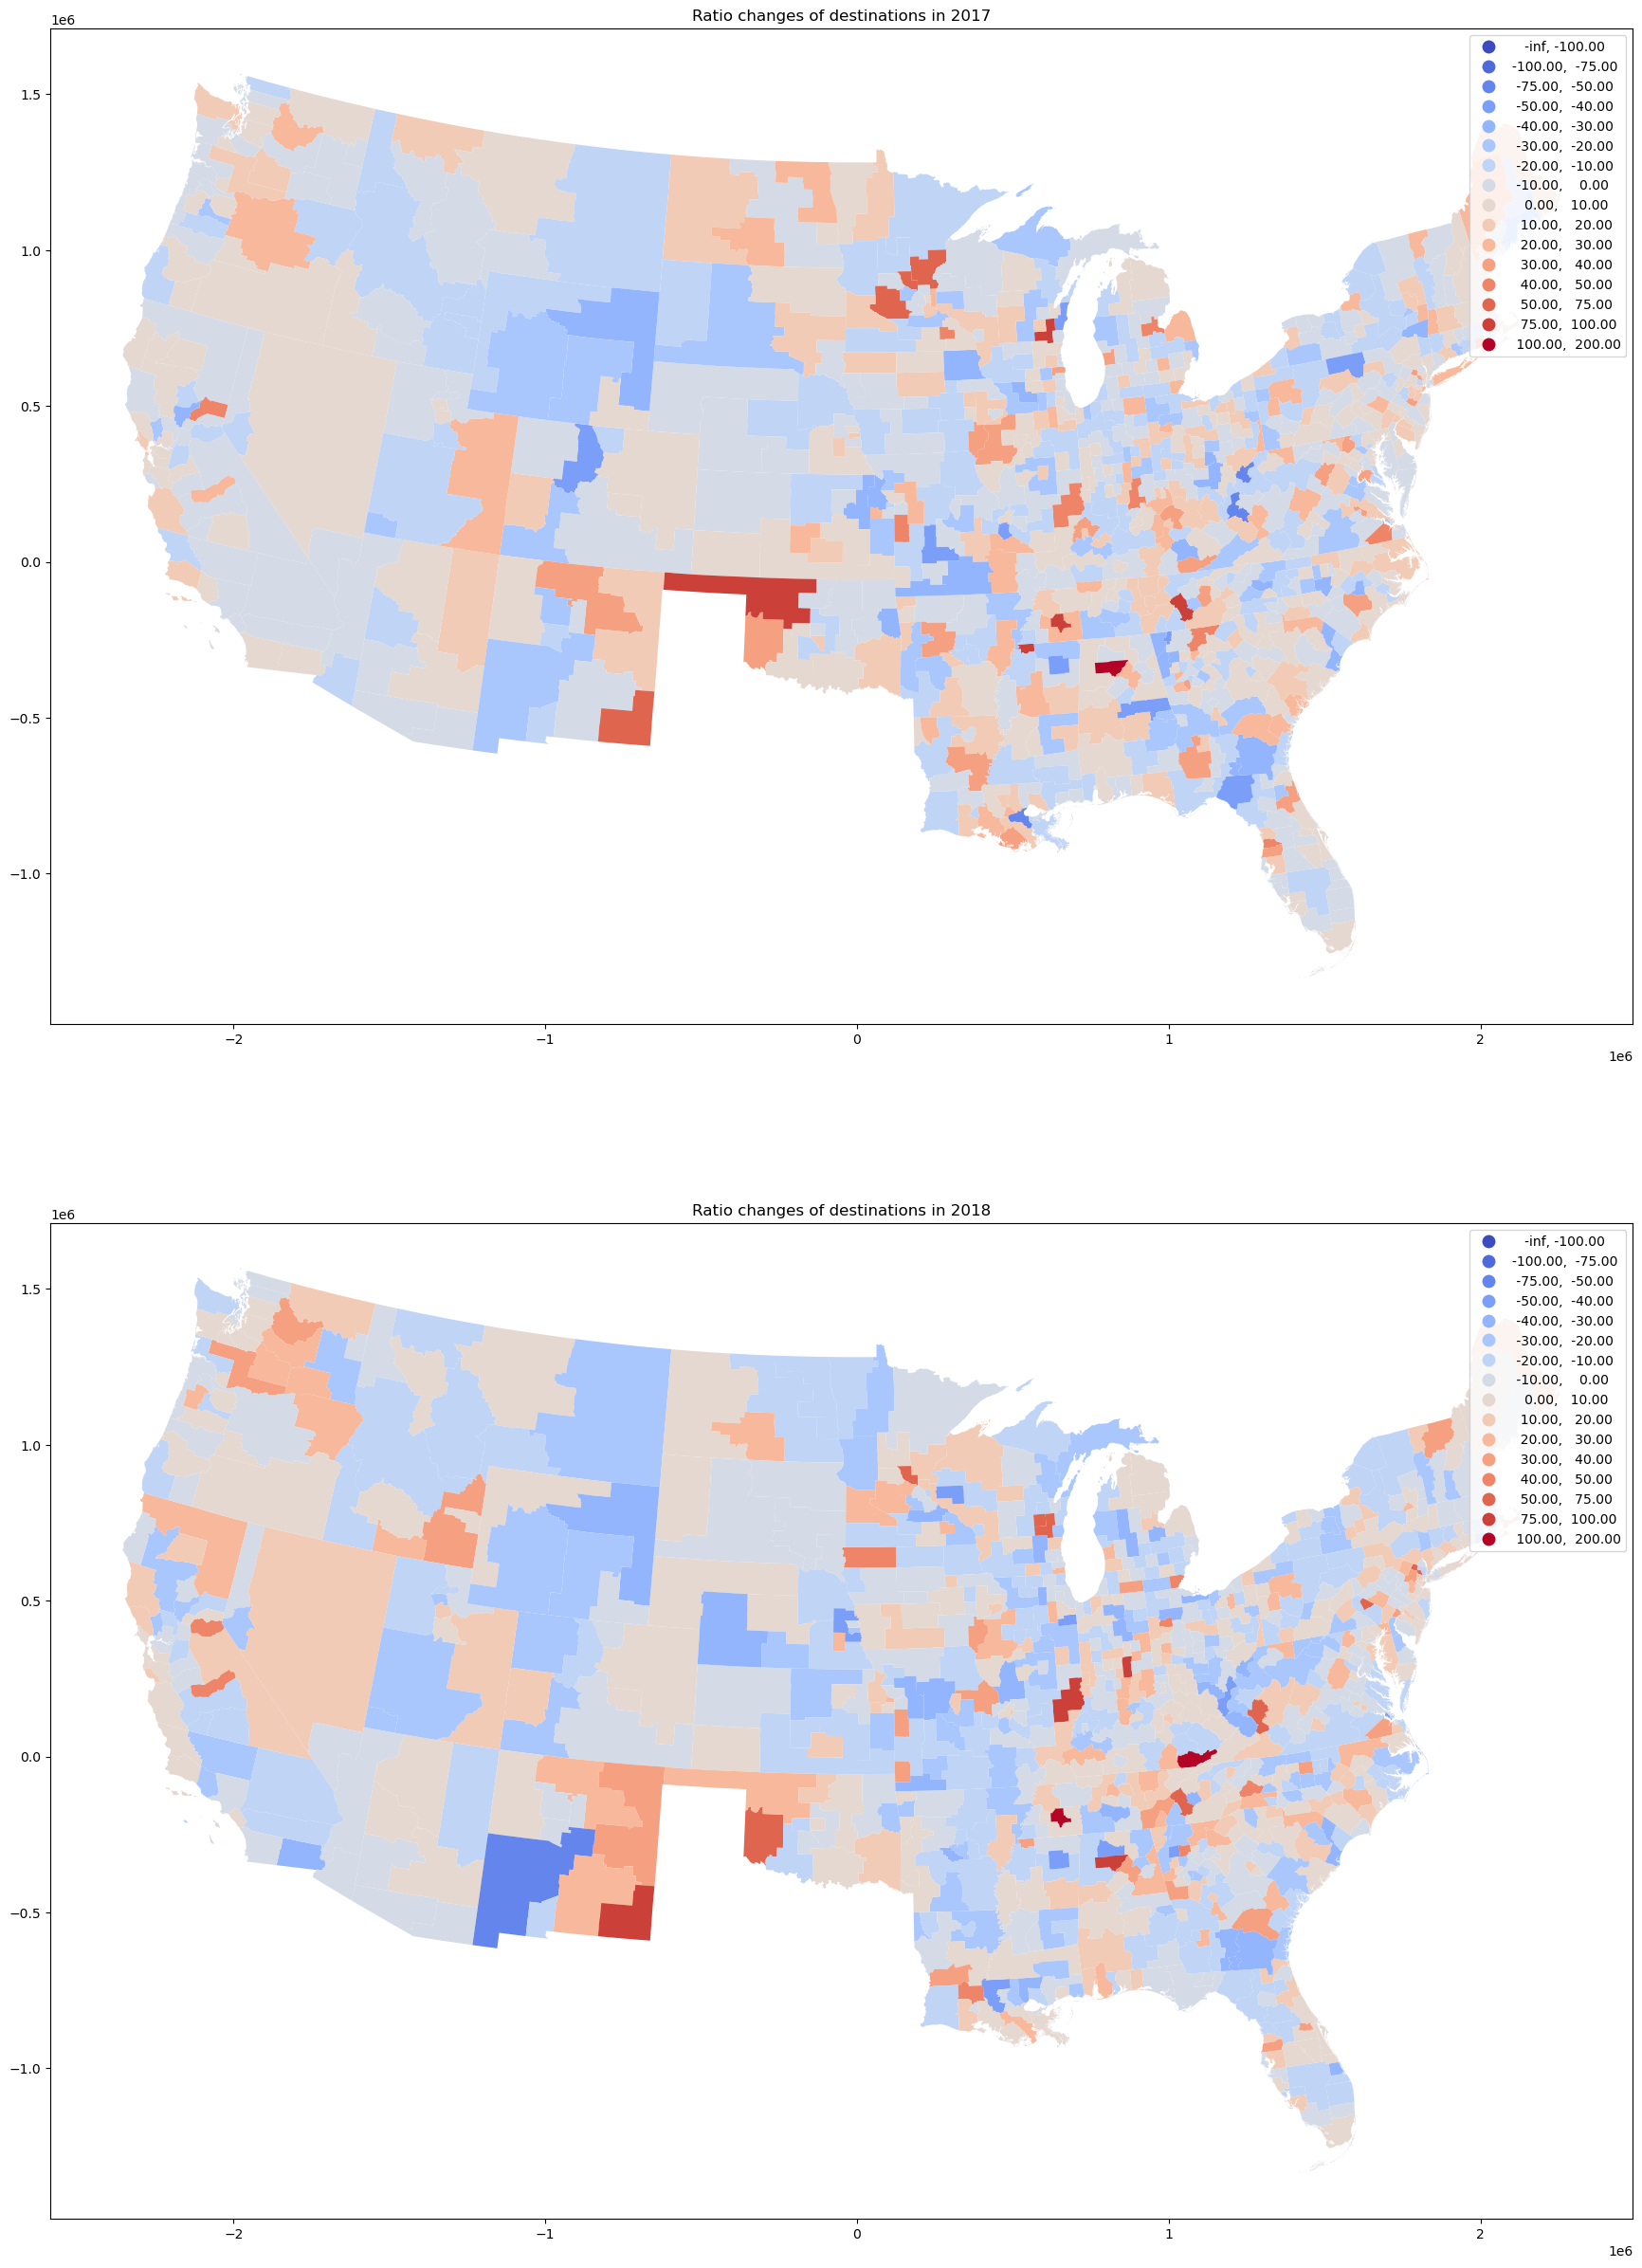

In [493]:
fig, axes = plt.subplots(2,1, figsize=(50, 30))
gdf_merge_flow_inter_prior_in_merge.plot(column="cr_prior_in",cmap="coolwarm",
                         scheme='userdefined',classification_kwds={'bins':[ -100, -75, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 75, 100, 200]},
                         legend=True,ax=axes[0],legend_kwds={'loc': 'best'})
axes[0].set_title("Ratio changes of destinations in 2017")
gdf_merge_flow_inter_prior_post1_merge.plot(column="cr_prior_post1",cmap="coolwarm",
                         scheme='userdefined',classification_kwds={'bins':[ -100, -75, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 75, 100, 200]},
                         legend=True,ax=axes[1],legend_kwds={'loc': 'best'})
axes[1].set_title("Ratio changes of destinations in 2018")

In [501]:
gdf_flow_inter_prior_in_merge_county = pd.merge(gdf_merge_flow_inter_prior_in_merge,df_migpuma_county,left_on="MIGPUMA2",right_on="MIGPUMA2")
gdf_flow_inter_prior_post1_merge_county = pd.merge(gdf_merge_flow_inter_prior_post1_merge,df_migpuma_county,left_on="MIGPUMA2",right_on="MIGPUMA2")

In [504]:
gdf_flow_inter_prior_in_merge_county_SHELDUS = pd.merge(gdf_flow_inter_prior_in_merge_county,SHELDUS_select_count_group,left_on="FIPS",right_on="County FIPS")
gdf_flow_inter_prior_post1_merge_county_SHELDUS = pd.merge(gdf_flow_inter_prior_post1_merge_county,SHELDUS_select_count_group,left_on="FIPS",right_on="County FIPS")

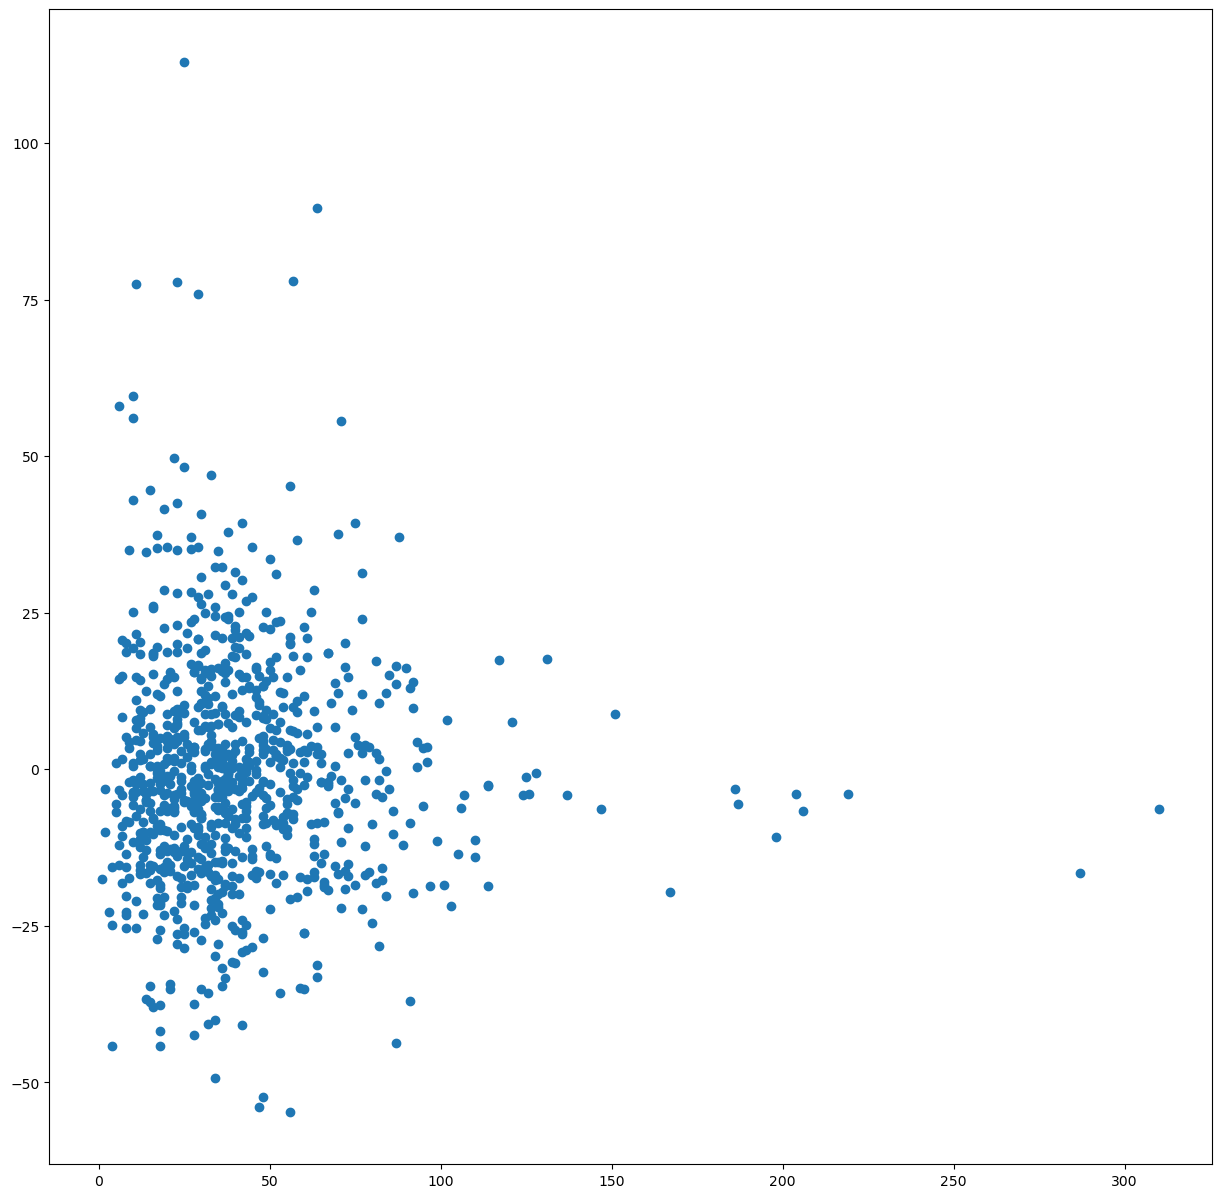

In [508]:
plt.scatter(gdf_flow_inter_prior_in_merge_county_SHELDUS["count"],gdf_flow_inter_prior_in_merge_county_SHELDUS["cr_prior_in"])
corr= pearsonr(gdf_flow_inter_prior_in_merge_county_SHELDUS["count"],gdf_flow_inter_prior_in_merge_county_SHELDUS["cr_prior_in"])

In [509]:
corr

PearsonRResult(statistic=-0.029344878502780933, pvalue=0.3781719567441517)

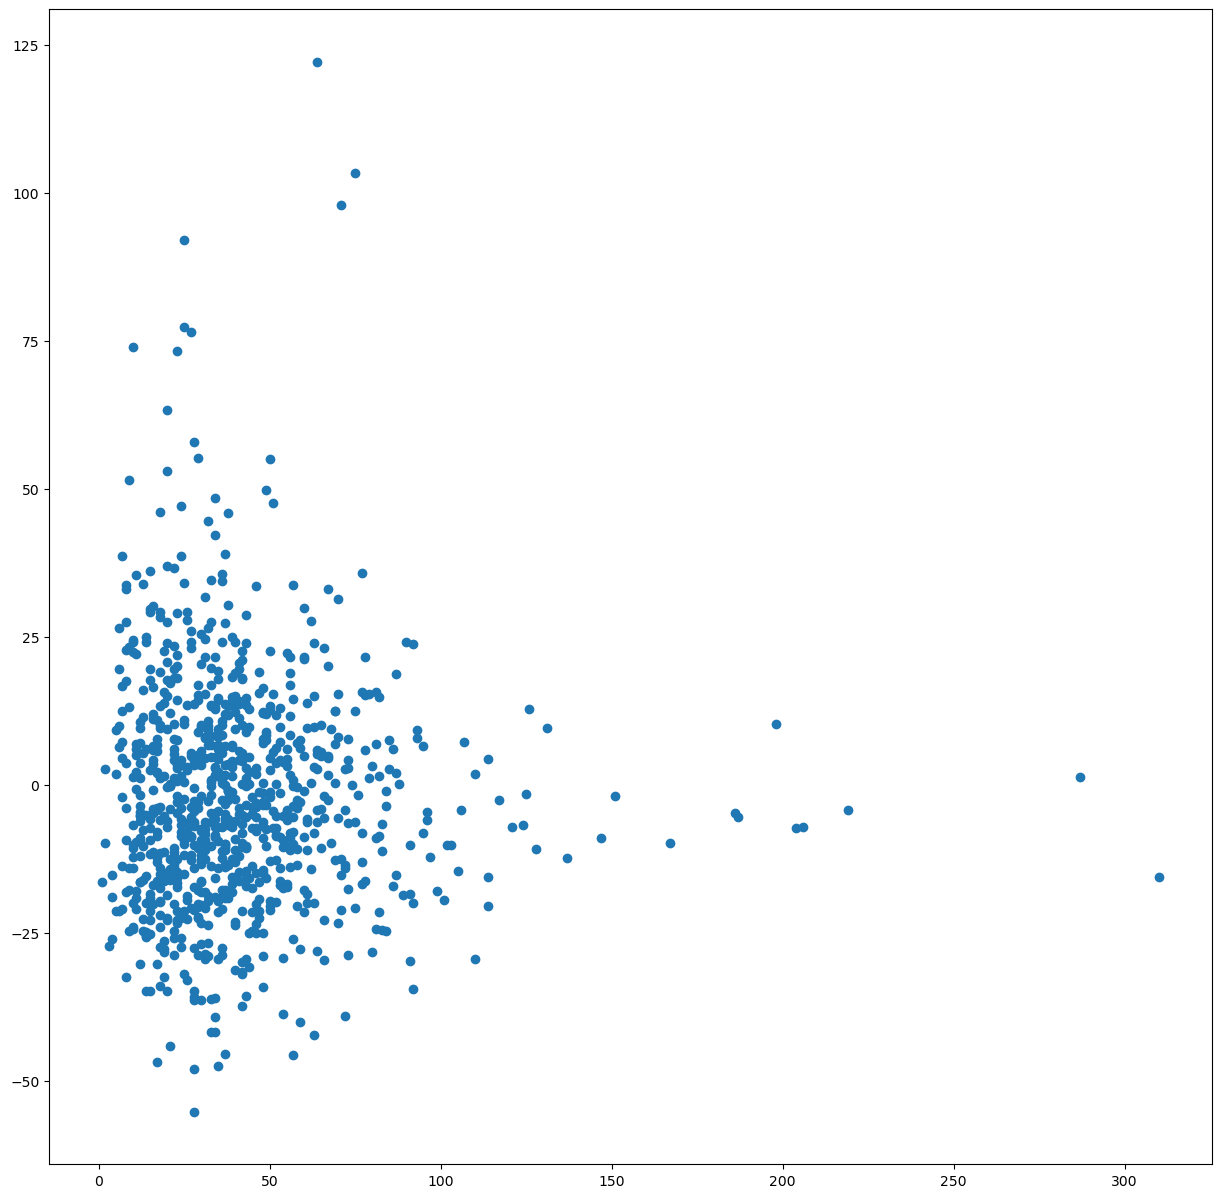

In [511]:
plt.scatter(gdf_flow_inter_prior_post1_merge_county_SHELDUS["count"],gdf_flow_inter_prior_post1_merge_county_SHELDUS["cr_prior_post1"])
corr2= pearsonr(gdf_flow_inter_prior_post1_merge_county_SHELDUS["count"],gdf_flow_inter_prior_post1_merge_county_SHELDUS["cr_prior_post1"])

In [512]:
corr2

PearsonRResult(statistic=-0.023778503721332493, pvalue=0.4751960508557149)

In [519]:
gdf_flow_inter_prior_in_group_state = gdf_flow_inter_prior_in_merge_county_SHELDUS.groupby("State_x").agg({"PWGTP_AVG":"sum","PWGTP_2017":"sum","count":"sum"}).reset_index()
gdf_flow_inter_prior_post1_group_state = gdf_flow_inter_prior_post1_merge_county_SHELDUS.groupby("State_x").agg({"PWGTP_AVG":"sum","PWGTP_2018":"sum","count":"sum"}).reset_index()

In [521]:
gdf_flow_inter_prior_in_group_state["cr_prior_in"] = (gdf_flow_inter_prior_in_group_state["PWGTP_2017"] - gdf_flow_inter_prior_in_group_state["PWGTP_AVG"]) / gdf_flow_inter_prior_in_group_state["PWGTP_AVG"]*100
gdf_flow_inter_prior_post1_group_state["cr_prior_post1"] = (gdf_flow_inter_prior_post1_group_state["PWGTP_2018"] - gdf_flow_inter_prior_post1_group_state["PWGTP_AVG"]) / gdf_flow_inter_prior_post1_group_state["PWGTP_AVG"]*100

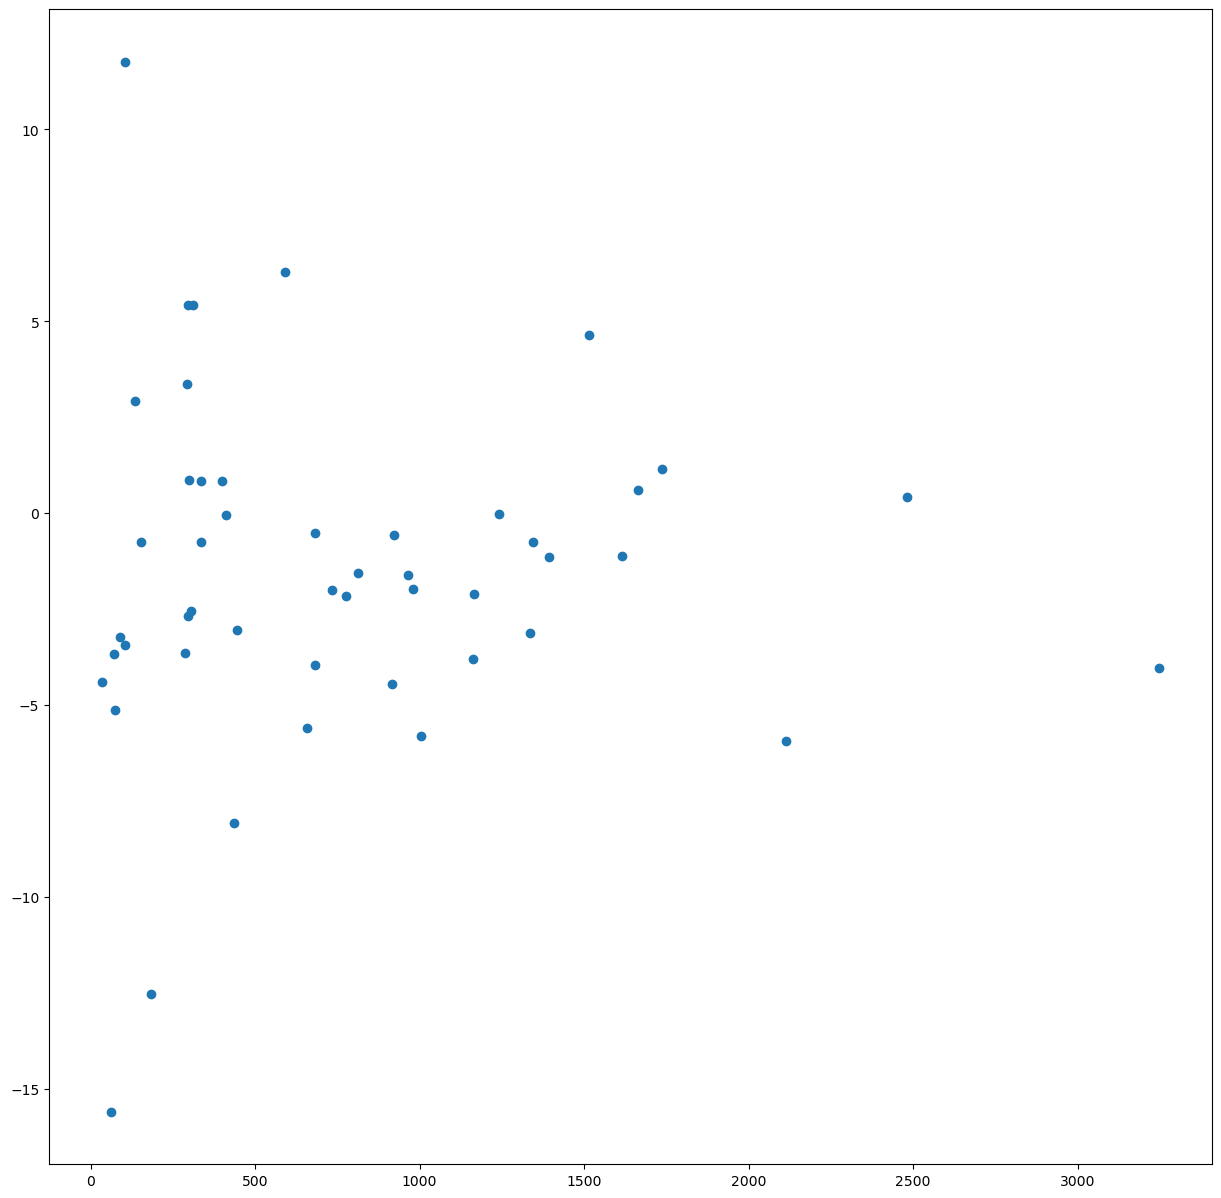

In [523]:
plt.scatter(gdf_flow_inter_prior_in_group_state["count"],gdf_flow_inter_prior_in_group_state["cr_prior_in"])
corr3= pearsonr(gdf_flow_inter_prior_in_group_state["count"],gdf_flow_inter_prior_in_group_state["cr_prior_in"])

In [524]:
corr3

PearsonRResult(statistic=0.017969342043131102, pvalue=0.9035141682261478)

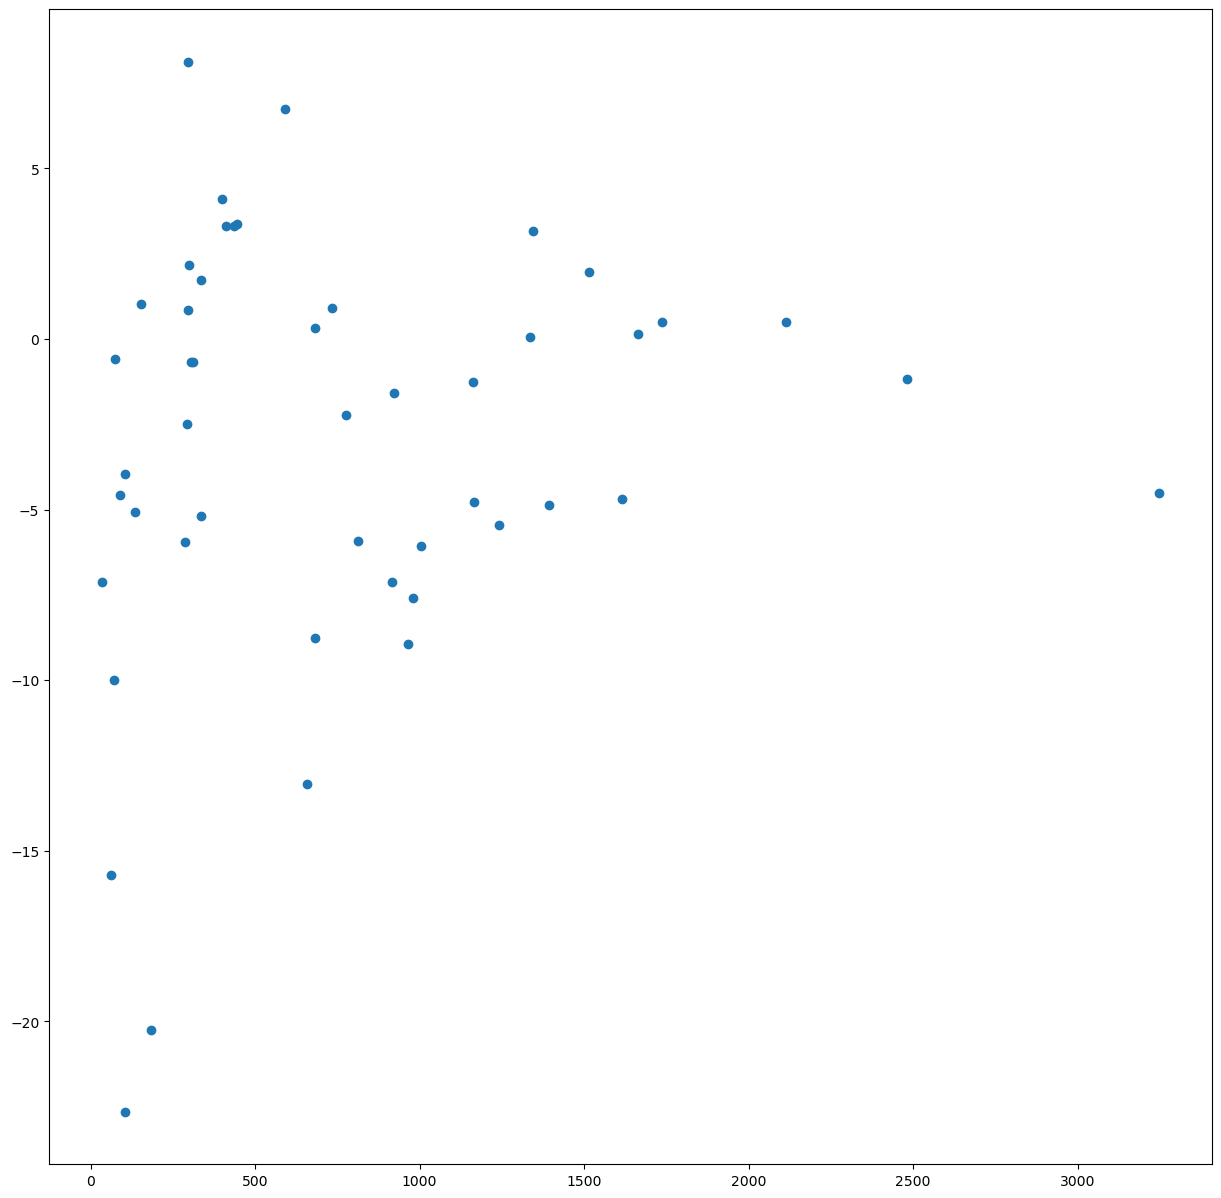

In [525]:
plt.scatter(gdf_flow_inter_prior_post1_group_state["count"],gdf_flow_inter_prior_post1_group_state["cr_prior_post1"])
corr4= pearsonr(gdf_flow_inter_prior_post1_group_state["count"],gdf_flow_inter_prior_post1_group_state["cr_prior_post1"])

In [526]:
corr4

PearsonRResult(statistic=0.14840627687262153, pvalue=0.3140912812536172)

## Talk about the different movement patterns in education, race, poverty <a id = "socialeco"></a>

In [531]:
df_edu = df2[~df2['SCHL'].isna()]

In [535]:
df_edu = df_edu.reset_index(drop=True)

### Defination
column is SCHL (Educational attainment)
1. Level 1: No School (00-01)
2. Level 2: High school degree and below (02-17)
3. Level 3: College (18-21)
4. Level 4: Professional degree beyond a bachelor degree (22-24)

In [536]:
education_level_list = []
for i in range(len(df_edu)):
    schl = df_edu.SCHL[i]
    if  schl == 1:
        level = 1
    elif schl <= 17 and schl >= 2:
        level = 2
    elif schl <= 21 and schl >= 18:
        level = 3
    elif schl >= 22:
        level = 4
    education_level_list.append(level)

In [537]:
df_edu["Education"] = education_level_list
df_edu.head()

RT       SERIALNO  DIVISION  SPORDER PUMA_x  REGION ST_x   ADJINC  PWGTP  \
0  P  2015000000067         6        3  02701       3   01  1080470     12   
1  P  2015000001052         6        1  02600       3   01  1080470      4   
2  P  2015000001890         6        1  01900       3   01  1080470      4   
3  P  2015000001898         6        2  00600       3   01  1080470     16   
4  P  2015000002757         6        1  02500       3   01  1080470      9   

   AGEP  CIT  CITWP  COW  DDRS  DEAR  DEYE  DOUT  DPHY  DRAT  DRATX  DREM  \
0     8    1    NaN  NaN   2.0     2     2   NaN   2.0   NaN    NaN   2.0   
1    47    1    NaN  1.0   2.0     2     2   2.0   2.0   NaN    2.0   2.0   
2    18    1    NaN  1.0   2.0     2     2   2.0   2.0   NaN    NaN   2.0   
3    21    1    NaN  1.0   2.0     2     2   2.0   2.0   NaN    NaN   2.0   
4    56    1    NaN  NaN   2.0     2     2   2.0   2.0   NaN    NaN   1.0   

   ENG  FER  GCL  GCM  GCR  HINS1  HINS2  HINS3  HINS4  HINS5  HINS6  HINS7  \
0  NaN  NaN  NaN  NaN  NaN      2      2      2      1      2      2      2   
1  NaN  NaN  2.0  NaN  NaN      2      2      2      1      2      2      2   
2  NaN  2.0  NaN  NaN  NaN      2      1      2      2      2      2      2   
3  NaN  NaN  NaN  NaN  NaN      1      2      2      2      2      2      2   
4  NaN  NaN  2.0  NaN  NaN      2      2      2      1      2      2      2   

   INTP  JWMNP  JWRIP  JWTRNS  LANX  MAR  MARHD  MARHM  MARHT  MARHW  MARHYP  \
0   NaN    NaN    NaN     NaN   2.0    5    NaN    NaN    NaN    NaN     NaN   
1   0.0    NaN    NaN     NaN   2.0    2    2.0    2.0    1.0    2.0  2006.0   
2   0.0    NaN    NaN     NaN   2.0    5    NaN    NaN    NaN    NaN     NaN   
3   0.0  130.0    1.0     1.0   2.0    5    NaN    NaN    NaN    NaN     NaN   
4   0.0    NaN    NaN     NaN   2.0    1    2.0    2.0    1.0    2.0  1996.0   

   MIG  MIL  MLPA  MLPB  MLPCD  MLPE  MLPFG  MLPH  MLPI  MLPJ  MLPK  NWAB  \
0  3.0  NaN   NaN   NaN    NaN   NaN    NaN   NaN   NaN   NaN   NaN   NaN   
1  3.0  3.0   NaN   NaN    NaN   NaN    NaN   NaN   NaN   NaN   NaN   2.0   
2  3.0  4.0   NaN   NaN    NaN   NaN    NaN   NaN   NaN   NaN   NaN   2.0   
3  3.0  4.0   NaN   NaN    NaN   NaN    NaN   NaN   NaN   NaN   NaN   3.0   
4  3.0  4.0   NaN   NaN    NaN   NaN    NaN   NaN   NaN   NaN   NaN   2.0   

   NWAV  NWLA  NWLK  NWRE  OIP  PAP  RELSHIPP  RETP  SCH  SCHG  SCHL  SEMP  \
0   NaN   NaN   NaN   NaN  NaN  NaN        30   NaN  2.0   5.0   5.0   NaN   
1   5.0   2.0   2.0   3.0  0.0  0.0        38   0.0  1.0   NaN  16.0   0.0   
2   5.0   2.0   2.0   3.0  0.0  0.0        38   0.0  2.0  15.0  16.0   0.0   
3   5.0   3.0   3.0   3.0  0.0  0.0        33   0.0  1.0   NaN  16.0   0.0   
4   5.0   2.0   2.0   3.0  0.0  0.0        20   0.0  1.0   NaN  11.0   0.0   

   SEX    SSIP  SSP     WAGP  WKHP  WKL  WKW  WKWN  WRK  YOEP  ANC  ANC1P  \
0    2     NaN  NaN      NaN   NaN  NaN  NaN   NaN  NaN   NaN    4    999   
1    1     0.0  0.0      0.0   NaN  2.0  NaN   NaN  2.0   NaN    1    902   
2    2     0.0  0.0  30000.0  12.0  1.0  1.0   NaN  2.0   NaN    1     26   
3    1     0.0  0.0  10000.0  40.0  1.0  1.0   NaN  1.0   NaN    1    924   
4    2  8200.0  0.0      0.0   NaN  3.0  NaN   NaN  2.0   NaN    1    902   

   ANC2P  DECADE  DIS  DRIVESP  ESP  ESR  FOD1P  FOD2P  HICOV  HISP    INDP  \
0    999     NaN    2      NaN  NaN  NaN    NaN    NaN      1     1     NaN   
1    999     NaN    2      NaN  NaN  6.0    NaN    NaN      1     1  3570.0   
2    999     NaN    2      NaN  NaN  6.0    NaN    NaN      1     1  8680.0   
3    999     NaN    2      1.0  NaN  1.0    NaN    NaN      1     1  5381.0   
4    999     NaN    1      NaN  NaN  6.0    NaN    NaN      1     1     NaN   

    JWAP  JWDP  LANP MIGPUMA_x MIGSP_x  MSP NAICSP  NATIVITY  NOP  ...  FRETP  \
0    NaN   NaN   NaN     02700      01  NaN    NaN         1  NaN  ...      0   
1    NaN   NaN   NaN     02400      01  3.0   336M         1  NaN  ...      0   
2

In [539]:
df_edu_af = df_edu.loc[df_edu["MIGPUMA_O"].isin(affected_migpuma)].reset_index()

In [541]:
df_edu_af_group = df_edu_af.groupby(["year","MIGPUMA_O","MIGPUMA_D","Education"]).sum("PWGTP").reset_index()

In [642]:
df_edu_af_group = df_edu_af_group[["year","MIGPUMA_O","MIGPUMA_D","Education","PWGTP"]]

In [649]:
def net_pop(df):
    df["O_D"] = df["MIGPUMA_O"]+df["MIGPUMA_D"]
    df["D_O"] = df["MIGPUMA_D"]+df["MIGPUMA_O"]
    df_New = pd.DataFrame()
    for i in range(len(df)):
        calc = df[df["D_O"].str.contains(df["O_D"][i])]
        if calc.empty == False:
            new = calc
        else:
            new = pd.DataFrame({"year":"2019","MIGPUMA_O":"0","MIGPUMA_D":"0","Education":0,"PWGTP":0,"O_D":"0","D_O":"0"},index=[i])
        df_New = df_New.append(new)
    df_New = df_New.reset_index(drop=True)
    df["PWGTP2"] = df_New["PWGTP"]
    df["net_pop"] = df["PWGTP"] - df["PWGTP2"]
    df = df[df["net_pop"]>0]
    df = df[["MIGPUMA_O","year","MIGPUMA_D","PWGTP","PWGTP2","net_pop","Education"]]
    return df

In [650]:
df_flow_in_texas_edu_2015 = df_edu_af_group.loc[df_edu_af_group["year"].isin(["2015"])].reset_index(drop=True)
df_flow_in_texas_edu_2016 = df_edu_af_group.loc[df_edu_af_group["year"].isin(["2016"])].reset_index(drop=True)
df_flow_in_texas_edu_2017 = df_edu_af_group.loc[df_edu_af_group["year"].isin(["2017"])].reset_index(drop=True)
df_flow_in_texas_edu_2018 = df_edu_af_group.loc[df_edu_af_group["year"].isin(["2018"])].reset_index(drop=True)
df_flow_in_texas_edu_2019 = df_edu_af_group.loc[df_edu_af_group["year"].isin(["2019"])].reset_index(drop=True)

In [569]:
def uniqueName3(df):
    name = str(df.year.unique()[0])
    df = df.rename(columns={"MIGPUMA_O": "MIGPUMA_O_"+name,
                            "year":"year_"+name,
                            "MIGPUMA_D":"MIGPUMA_D_"+name,
                            "Education":"Education_"+name,
                            "PWGTP":"PWGTP_"+name})
    return df

In [651]:
df_flow_in_texas_2015_net = net_pop(df_flow_in_texas_edu_2015)
df_flow_in_texas_2016_net = net_pop(df_flow_in_texas_edu_2016)
df_flow_in_texas_2017_net = net_pop(df_flow_in_texas_edu_2017)
df_flow_in_texas_2018_net = net_pop(df_flow_in_texas_edu_2018)
df_flow_in_texas_2019_net = net_pop(df_flow_in_texas_edu_2019)

In [652]:
df_flow_in_texas_edu_2015 = uniqueName3(df_flow_in_texas_2015_net)
df_flow_in_texas_edu_2016 = uniqueName3(df_flow_in_texas_2016_net)
df_flow_in_texas_edu_2017 = uniqueName3(df_flow_in_texas_2017_net)
df_flow_in_texas_edu_2018 = uniqueName3(df_flow_in_texas_2018_net)
df_flow_in_texas_edu_2019 = uniqueName3(df_flow_in_texas_2019_net)

In [658]:
list_o_1 = list(merge_flow_in_15_16_edu["MIGPUMA_O_2015"])
list_o_2 = list(merge_flow_in_15_16_edu["MIGPUMA_O_2016"])
list_d_1 = list(merge_flow_in_15_16_edu["MIGPUMA_D_2015"])
list_d_2 = list(merge_flow_in_15_16_edu["MIGPUMA_D_2016"])
list_edu_1 = list(merge_flow_in_15_16_edu["Education_2015"])
list_edu_2 = list(merge_flow_in_15_16_edu["Education_2016"])
list_Pop = list(merge_flow_in_15_16_edu["net_pop_AVG"])

In [659]:
list_o  = []
list_d  = []
list_edu= []
for i in range(len(list_o_1)):
    if list_o_1[i] == 0:
        list_o.append(list_o_2[i])
    else:
        list_o.append(list_o_1[i])

for i in range(len(list_d_1)):
    if list_d_1[i] == 0:
        list_d.append(list_d_2[i])
    else:
        list_d.append(list_d_1[i])

for i in range(len(list_edu_1)):
    if list_edu_1[i] == 0:
        list_edu.append(list_edu_2[i])
    else:
        list_edu.append(list_edu_1[i])

In [660]:
df_flow_in_texas_edu_15_16 = pd.DataFrame(data={
    "MIGPUMA_O_Prior":list_o,
    "MIGPUMA_D_Prior":list_d,
    "Education":list_edu,
    "net_pop_Prior":list_Pop
})

In [661]:
df_flow_in_texas_edu_2015_local_1 = df_flow_in_texas_edu_15_16.loc[df_flow_in_texas_edu_15_16["MIGPUMA_O_Prior"].isin(affected_migpuma)]
df_flow_in_texas_edu_2015_local = df_flow_in_texas_edu_2015_local_1.loc[df_flow_in_texas_edu_2015_local_1["MIGPUMA_D_Prior"].isin(affected_migpuma)].reset_index(drop=True)
df_flow_in_texas_edu_2015_outflow_1 = df_flow_in_texas_edu_15_16.loc[df_flow_in_texas_edu_15_16["MIGPUMA_O_Prior"].isin(affected_migpuma)]
df_flow_in_texas_edu_2015_outflow = df_flow_in_texas_edu_2015_outflow_1.loc[df_flow_in_texas_edu_2015_outflow_1["MIGPUMA_D_Prior"].isin(migpuma_other_list)].reset_index(drop=True)

df_flow_in_texas_edu_2017_local_1 = df_flow_in_texas_edu_2017.loc[df_flow_in_texas_edu_2017["MIGPUMA_O_2017"].isin(affected_migpuma)]
df_flow_in_texas_edu_2017_local = df_flow_in_texas_edu_2017_local_1.loc[df_flow_in_texas_edu_2017_local_1["MIGPUMA_D_2017"].isin(affected_migpuma)].reset_index(drop=True)
df_flow_in_texas_edu_2017_outflow_1 = df_flow_in_texas_edu_2017.loc[df_flow_in_texas_edu_2017["MIGPUMA_O_2017"].isin(affected_migpuma)]
df_flow_in_texas_edu_2017_outflow = df_flow_in_texas_edu_2017_outflow_1.loc[df_flow_in_texas_edu_2017_outflow_1["MIGPUMA_D_2017"].isin(migpuma_other_list)].reset_index(drop=True)

df_flow_in_texas_edu_2018_local_1 = df_flow_in_texas_edu_2018.loc[df_flow_in_texas_edu_2018["MIGPUMA_O_2018"].isin(affected_migpuma)]
df_flow_in_texas_edu_2018_local = df_flow_in_texas_edu_2018_local_1.loc[df_flow_in_texas_edu_2018_local_1["MIGPUMA_D_2018"].isin(affected_migpuma)].reset_index(drop=True)
df_flow_in_texas_edu_2018_outflow_1 = df_flow_in_texas_edu_2018.loc[df_flow_in_texas_edu_2018["MIGPUMA_O_2018"].isin(affected_migpuma)]
df_flow_in_texas_edu_2018_outflow = df_flow_in_texas_edu_2018_outflow_1.loc[df_flow_in_texas_edu_2018_outflow_1["MIGPUMA_D_2018"].isin(migpuma_other_list)].reset_index(drop=True)

## local

In [662]:
df_edu_local_prior_in_merge = pd.merge(df_flow_in_texas_edu_2015_local,df_flow_in_texas_edu_2017_local,left_on=["MIGPUMA_O_Prior","MIGPUMA_D_Prior","Education"],right_on=["MIGPUMA_O_2017","MIGPUMA_D_2017","Education_2017"])
df_edu_local_prior_post1_merge = pd.merge(df_flow_in_texas_edu_2015_local,df_flow_in_texas_edu_2018_local,left_on=["MIGPUMA_O_Prior","MIGPUMA_D_Prior","Education"],right_on=["MIGPUMA_O_2018","MIGPUMA_D_2018","Education_2018"])

df_edu_outflow_prior_in_merge = pd.merge(df_flow_in_texas_edu_2015_outflow,df_flow_in_texas_edu_2017_outflow,left_on=["MIGPUMA_O_Prior","MIGPUMA_D_Prior","Education"],right_on=["MIGPUMA_O_2017","MIGPUMA_D_2017","Education_2017"])
df_edu_outflow_prior_post1_merge = pd.merge(df_flow_in_texas_edu_2015_outflow,df_flow_in_texas_edu_2018_outflow,left_on=["MIGPUMA_O_Prior","MIGPUMA_D_Prior","Education"],right_on=["MIGPUMA_O_2018","MIGPUMA_D_2018","Education_2018"])


In [664]:
df_edu_local_prior_in_merge = pd.merge(df_flow_in_texas_edu_2015_local,df_flow_in_texas_edu_2017_local,left_on=["MIGPUMA_O_Prior","MIGPUMA_D_Prior","Education"],right_on=["MIGPUMA_O_2017","MIGPUMA_D_2017","Education_2017"])
df_edu_local_prior_post1_merge = pd.merge(df_flow_in_texas_edu_2015_local,df_flow_in_texas_edu_2018_local,left_on=["MIGPUMA_O_Prior","MIGPUMA_D_Prior","Education"],right_on=["MIGPUMA_O_2018","MIGPUMA_D_2018","Education_2018"])

df_edu_outflow_prior_in_merge = pd.merge(df_flow_in_texas_edu_2015_outflow,df_flow_in_texas_edu_2017_outflow,left_on=["MIGPUMA_O_Prior","MIGPUMA_D_Prior","Education"],right_on=["MIGPUMA_O_2017","MIGPUMA_D_2017","Education_2017"])
df_edu_outflow_prior_post1_merge = pd.merge(df_flow_in_texas_edu_2015_outflow,df_flow_in_texas_edu_2018_outflow,left_on=["MIGPUMA_O_Prior","MIGPUMA_D_Prior","Education"],right_on=["MIGPUMA_O_2018","MIGPUMA_D_2018","Education_2018"])

df_edu_local_prior_in_merge["cr_prior_in"] = (df_edu_local_prior_in_merge["net_pop"] - df_edu_local_prior_in_merge["net_pop_Prior"]) / df_edu_local_prior_in_merge["net_pop_Prior"]*100
df_edu_local_prior_post1_merge["cr_prior_post1"] = (df_edu_local_prior_post1_merge["net_pop"] - df_edu_local_prior_post1_merge["net_pop_Prior"]) / df_edu_local_prior_post1_merge["net_pop_Prior"]*100

df_edu_outflow_prior_in_merge["cr_prior_in"] = (df_edu_outflow_prior_in_merge["net_pop"] - df_edu_outflow_prior_in_merge["net_pop_Prior"]) / df_edu_outflow_prior_in_merge["net_pop_Prior"]*100
df_edu_outflow_prior_post1_merge["cr_prior_post1"] = (df_edu_outflow_prior_post1_merge["net_pop"] - df_edu_outflow_prior_post1_merge["net_pop_Prior"]) / df_edu_outflow_prior_post1_merge["net_pop_Prior"]*100

In [665]:
df_flow_edu_local_prior_in_1 = df_edu_local_prior_in_merge[df_edu_local_prior_in_merge["Education"]==1].reset_index(drop=True)
df_flow_edu_local_prior_in_2 = df_edu_local_prior_in_merge[df_edu_local_prior_in_merge["Education"]==2].reset_index(drop=True)
df_flow_edu_local_prior_in_3 = df_edu_local_prior_in_merge[df_edu_local_prior_in_merge["Education"]==3].reset_index(drop=True)
df_flow_edu_local_prior_in_4 = df_edu_local_prior_in_merge[df_edu_local_prior_in_merge["Education"]==4].reset_index(drop=True)

df_flow_edu_local_prior_post1_1 = df_edu_local_prior_post1_merge[df_edu_local_prior_post1_merge["Education"]==1].reset_index(drop=True)
df_flow_edu_local_prior_post1_2 = df_edu_local_prior_post1_merge[df_edu_local_prior_post1_merge["Education"]==2].reset_index(drop=True)
df_flow_edu_local_prior_post1_3 = df_edu_local_prior_post1_merge[df_edu_local_prior_post1_merge["Education"]==3].reset_index(drop=True)
df_flow_edu_local_prior_post1_4 = df_edu_local_prior_post1_merge[df_edu_local_prior_post1_merge["Education"]==4].reset_index(drop=True)

df_flow_edu_outflow_prior_in_1 = df_edu_outflow_prior_in_merge[df_edu_outflow_prior_in_merge["Education"]==1].reset_index(drop=True)
df_flow_edu_outflow_prior_in_2 = df_edu_outflow_prior_in_merge[df_edu_outflow_prior_in_merge["Education"]==2].reset_index(drop=True)
df_flow_edu_outflow_prior_in_3 = df_edu_outflow_prior_in_merge[df_edu_outflow_prior_in_merge["Education"]==3].reset_index(drop=True)
df_flow_edu_outflow_prior_in_4 = df_edu_outflow_prior_in_merge[df_edu_outflow_prior_in_merge["Education"]==4].reset_index(drop=True)

df_flow_edu_outflow_prior_post1_1 = df_edu_outflow_prior_post1_merge[df_edu_outflow_prior_post1_merge["Education"]==1].reset_index(drop=True)
df_flow_edu_outflow_prior_post1_2 = df_edu_outflow_prior_post1_merge[df_edu_outflow_prior_post1_merge["Education"]==2].reset_index(drop=True)
df_flow_edu_outflow_prior_post1_3 = df_edu_outflow_prior_post1_merge[df_edu_outflow_prior_post1_merge["Education"]==3].reset_index(drop=True)
df_flow_edu_outflow_prior_post1_4 = df_edu_outflow_prior_post1_merge[df_edu_outflow_prior_post1_merge["Education"]==4].reset_index(drop=True)


In [666]:
def df_addxy(df):
    df_1 = pd.merge(df,migpuma_p,left_on="MIGPUMA_O_Prior",right_on="MIGPUMA2")
    df2  = pd.merge(df_1,migpuma_p,left_on="MIGPUMA_D_Prior",right_on="MIGPUMA2")
    return df2

In [667]:
df_flow_edu_local_prior_in_1 = df_addxy(df_flow_edu_local_prior_in_1)
df_flow_edu_local_prior_in_2 = df_addxy(df_flow_edu_local_prior_in_2)
df_flow_edu_local_prior_in_3 = df_addxy(df_flow_edu_local_prior_in_3)
df_flow_edu_local_prior_in_4 = df_addxy(df_flow_edu_local_prior_in_4)

df_flow_edu_local_prior_post1_1 = df_addxy(df_flow_edu_local_prior_post1_1)
df_flow_edu_local_prior_post1_2 = df_addxy(df_flow_edu_local_prior_post1_2)
df_flow_edu_local_prior_post1_3 = df_addxy(df_flow_edu_local_prior_post1_3)
df_flow_edu_local_prior_post1_4 = df_addxy(df_flow_edu_local_prior_post1_4)

df_flow_edu_outflow_prior_in_1 = df_addxy(df_flow_edu_outflow_prior_in_1)
df_flow_edu_outflow_prior_in_2 = df_addxy(df_flow_edu_outflow_prior_in_2)
df_flow_edu_outflow_prior_in_3 = df_addxy(df_flow_edu_outflow_prior_in_3)
df_flow_edu_outflow_prior_in_4 = df_addxy(df_flow_edu_outflow_prior_in_4)

df_flow_edu_outflow_prior_post1_1 = df_addxy(df_flow_edu_outflow_prior_post1_1)
df_flow_edu_outflow_prior_post1_2 = df_addxy(df_flow_edu_outflow_prior_post1_2)
df_flow_edu_outflow_prior_post1_3 = df_addxy(df_flow_edu_outflow_prior_post1_3)
df_flow_edu_outflow_prior_post1_4 = df_addxy(df_flow_edu_outflow_prior_post1_4)

In [673]:
df_line = pd.DataFrame()
df_line["geometry"] = df_flow_edu_local_prior_in_1.apply(lambda x: LineString([x["geometry_x"],x["geometry_y"]]),axis=1)
df_line = gpd.GeoDataFrame(df_line,geometry="geometry",crs = 'ESRI:102003').to_crs("EPSG:4326")
df_line[["PWGTP_Prior","PWGTP_In","MIGPUMA_O","MIGPUMA_D"]] = df_flow_edu_local_prior_in_1[["net_pop_Prior","net_pop","MIGPUMA_O_Prior","MIGPUMA_D_Prior"]]
df_line2 = pd.DataFrame()
df_line2["geometry"] = df_flow_edu_local_prior_in_2.apply(lambda x: LineString([x["geometry_x"],x["geometry_y"]]),axis=1)
df_line2 = gpd.GeoDataFrame(df_line2,geometry="geometry",crs = 'ESRI:102003').to_crs("EPSG:4326")
df_line2[["PWGTP_Prior","PWGTP_In","MIGPUMA_O","MIGPUMA_D"]] = df_flow_edu_local_prior_in_2[["net_pop_Prior","net_pop","MIGPUMA_O_Prior","MIGPUMA_D_Prior"]]
df_line3 = pd.DataFrame()
df_line3["geometry"] = df_flow_edu_local_prior_in_3.apply(lambda x: LineString([x["geometry_x"],x["geometry_y"]]),axis=1)
df_line3 = gpd.GeoDataFrame(df_line3,geometry="geometry",crs = 'ESRI:102003').to_crs("EPSG:4326")
df_line3[["PWGTP_Prior","PWGTP_In","MIGPUMA_O","MIGPUMA_D"]] = df_flow_edu_local_prior_in_3[["net_pop_Prior","net_pop","MIGPUMA_O_Prior","MIGPUMA_D_Prior"]]
df_line4 = pd.DataFrame()
df_line4["geometry"] = df_flow_edu_local_prior_in_4.apply(lambda x: LineString([x["geometry_x"],x["geometry_y"]]),axis=1)
df_line4 = gpd.GeoDataFrame(df_line4,geometry="geometry",crs = 'ESRI:102003').to_crs("EPSG:4326")
df_line4[["PWGTP_Prior","PWGTP_In","MIGPUMA_O","MIGPUMA_D"]] = df_flow_edu_local_prior_in_4[["net_pop_Prior","net_pop","MIGPUMA_O_Prior","MIGPUMA_D_Prior"]]

df_line5 = pd.DataFrame()
df_line5["geometry"] = df_flow_edu_local_prior_post1_1.apply(lambda x: LineString([x["geometry_x"],x["geometry_y"]]),axis=1)
df_line5 = gpd.GeoDataFrame(df_line5,geometry="geometry",crs = 'ESRI:102003').to_crs("EPSG:4326")
df_line5[["PWGTP_Prior","PWGTP_Post1","MIGPUMA_O","MIGPUMA_D"]] = df_flow_edu_local_prior_post1_1[["net_pop_Prior","net_pop","MIGPUMA_O_Prior","MIGPUMA_D_Prior"]]
df_line6 = pd.DataFrame()
df_line6["geometry"] = df_flow_edu_local_prior_post1_2.apply(lambda x: LineString([x["geometry_x"],x["geometry_y"]]),axis=1)
df_line6 = gpd.GeoDataFrame(df_line6,geometry="geometry",crs = 'ESRI:102003').to_crs("EPSG:4326")
df_line6[["PWGTP_Prior","PWGTP_Post1","MIGPUMA_O","MIGPUMA_D"]] = df_flow_edu_local_prior_post1_2[["net_pop_Prior","net_pop","MIGPUMA_O_Prior","MIGPUMA_D_Prior"]]
df_line7 = pd.DataFrame()
df_line7["geometry"] = df_flow_edu_local_prior_post1_3.apply(lambda x: LineString([x["geometry_x"],x["geometry_y"]]),axis=1)
df_line7 = gpd.GeoDataFrame(df_line7,geometry="geometry",crs = 'ESRI:102003').to_crs("EPSG:4326")
df_line7[["PWGTP_Prior","PWGTP_Post1","MIGPUMA_O","MIGPUMA_D"]] = df_flow_edu_local_prior_post1_3[["net_pop_Prior","net_pop","MIGPUMA_O_Prior","MIGPUMA_D_Prior"]]
df_line8 = pd.DataFrame()
df_line8["geometry"] = df_flow_edu_local_prior_post1_4.apply(lambda x: LineString([x["geometry_x"],x["geometry_y"]]),axis=1)
df_line8 = gpd.GeoDataFrame(df_line8,geometry="geometry",crs = 'ESRI:102003').to_crs("EPSG:4326")
df_line8[["PWGTP_Prior","PWGTP_Post1","MIGPUMA_O","MIGPUMA_D"]] = df_flow_edu_local_prior_post1_4[["net_pop_Prior","net_pop","MIGPUMA_O_Prior","MIGPUMA_D_Prior"]]                                                                                        

In [674]:
gdf_edu_local_prior_in_1    = x_y_o_d(df_line)
gdf_edu_local_prior_in_2    = x_y_o_d(df_line2)
gdf_edu_local_prior_in_3    = x_y_o_d(df_line3)
gdf_edu_local_prior_in_4    = x_y_o_d(df_line4)

gdf_edu_local_prior_post1_1 = x_y_o_d(df_line5)
gdf_edu_local_prior_post1_2 = x_y_o_d(df_line6)
gdf_edu_local_prior_post1_3 = x_y_o_d(df_line7)
gdf_edu_local_prior_post1_4 = x_y_o_d(df_line8)

In [675]:
gdf_edu_local_prior_in_1["cr_prior_in"] = (gdf_edu_local_prior_in_1["PWGTP_In"] - gdf_edu_local_prior_in_1["PWGTP_Prior"]) / gdf_edu_local_prior_in_1["PWGTP_Prior"]*100
gdf_edu_local_prior_post1_1["cr_prior_post1"] = (gdf_edu_local_prior_post1_1["PWGTP_Post1"] - gdf_edu_local_prior_post1_1["PWGTP_Prior"]) / gdf_edu_local_prior_post1_1["PWGTP_Prior"]*100
gdf_edu_local_prior_in_2["cr_prior_in"] = (gdf_edu_local_prior_in_2["PWGTP_In"] - gdf_edu_local_prior_in_2["PWGTP_Prior"]) / gdf_edu_local_prior_in_2["PWGTP_Prior"]*100
gdf_edu_local_prior_post1_2["cr_prior_post1"] = (gdf_edu_local_prior_post1_2["PWGTP_Post1"] - gdf_edu_local_prior_post1_2["PWGTP_Prior"]) / gdf_edu_local_prior_post1_2["PWGTP_Prior"]*100
gdf_edu_local_prior_in_3["cr_prior_in"] = (gdf_edu_local_prior_in_3["PWGTP_In"] - gdf_edu_local_prior_in_3["PWGTP_Prior"]) / gdf_edu_local_prior_in_3["PWGTP_Prior"]*100
gdf_edu_local_prior_post1_3["cr_prior_post1"] = (gdf_edu_local_prior_post1_3["PWGTP_Post1"] - gdf_edu_local_prior_post1_3["PWGTP_Prior"]) / gdf_edu_local_prior_post1_3["PWGTP_Prior"]*100
gdf_edu_local_prior_in_4["cr_prior_in"] = (gdf_edu_local_prior_in_4["PWGTP_In"] - gdf_edu_local_prior_in_4["PWGTP_Prior"]) / gdf_edu_local_prior_in_4["PWGTP_Prior"]*100
gdf_edu_local_prior_post1_4["cr_prior_post1"] = (gdf_edu_local_prior_post1_4["PWGTP_Post1"] - gdf_edu_local_prior_post1_4["PWGTP_Prior"]) / gdf_edu_local_prior_post1_4["PWGTP_Prior"]*100

Text(0.5, 1.0, 'Local flow of level 4 of education in 2017\n compared to baseline')

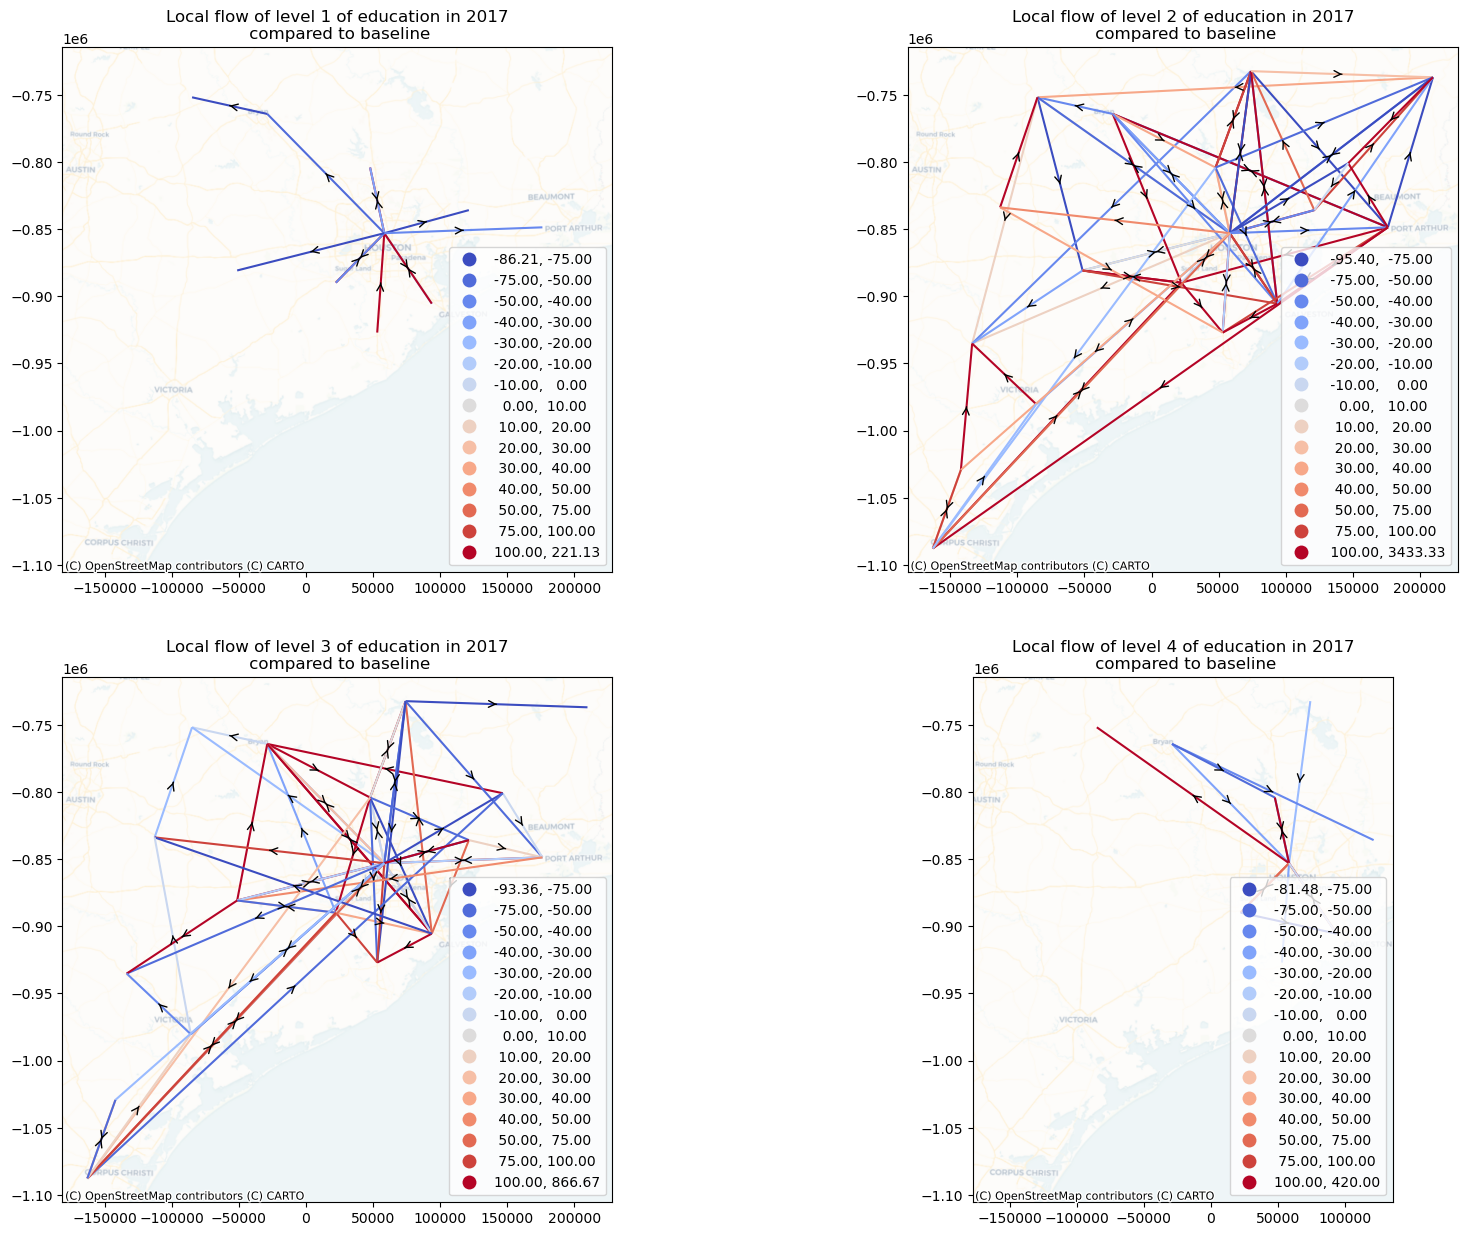

In [676]:
fig, axes = plt.subplots(2,2,figsize=(20,15))
for i in range(len(gdf_edu_local_prior_in_1)):
    x0 = gdf_edu_local_prior_in_1[i:i+1]["x_o"]
    x1 = gdf_edu_local_prior_in_1[i:i+1]["x_d"]
    y0 = gdf_edu_local_prior_in_1[i:i+1]["y_o"]
    y1 = gdf_edu_local_prior_in_1[i:i+1]["y_d"]
    xpos = (x0+x1)/2
    ypos = (y0+y1)/2
    xdir = x1-x0
    ydir = y1-y0
    for X,Y,dX,dY in zip(xpos, ypos, xdir, ydir):
        axes[0,0].annotate("", xytext=(X,Y),xy=(X+0.001*dX,Y+0.001*dY), 
        arrowprops=dict(arrowstyle="->", color='k'), size = 12)
for i in range(len(gdf_edu_local_prior_in_2)):
    x0 = gdf_edu_local_prior_in_2[i:i+1]["x_o"]
    x1 = gdf_edu_local_prior_in_2[i:i+1]["x_d"]
    y0 = gdf_edu_local_prior_in_2[i:i+1]["y_o"]
    y1 = gdf_edu_local_prior_in_2[i:i+1]["y_d"]
    xpos = (x0+x1)/2
    ypos = (y0+y1)/2
    xdir = x1-x0
    ydir = y1-y0
    for X,Y,dX,dY in zip(xpos, ypos, xdir, ydir):
        axes[0,1].annotate("", xytext=(X,Y),xy=(X+0.001*dX,Y+0.001*dY), 
        arrowprops=dict(arrowstyle="->", color='k'), size = 12)
for i in range(len(gdf_edu_local_prior_in_3)):
    x0 = gdf_edu_local_prior_in_3[i:i+1]["x_o"]
    x1 = gdf_edu_local_prior_in_3[i:i+1]["x_d"]
    y0 = gdf_edu_local_prior_in_3[i:i+1]["y_o"]
    y1 = gdf_edu_local_prior_in_3[i:i+1]["y_d"]
    xpos = (x0+x1)/2
    ypos = (y0+y1)/2
    xdir = x1-x0
    ydir = y1-y0
    for X,Y,dX,dY in zip(xpos, ypos, xdir, ydir):
        axes[1,0].annotate("", xytext=(X,Y),xy=(X+0.001*dX,Y+0.001*dY), 
        arrowprops=dict(arrowstyle="->", color='k'), size = 12)
for i in range(len(gdf_edu_local_prior_in_4)):
    x0 = gdf_edu_local_prior_in_4[i:i+1]["x_o"]
    x1 = gdf_edu_local_prior_in_4[i:i+1]["x_d"]
    y0 = gdf_edu_local_prior_in_4[i:i+1]["y_o"]
    y1 = gdf_edu_local_prior_in_4[i:i+1]["y_d"]
    xpos = (x0+x1)/2
    ypos = (y0+y1)/2
    xdir = x1-x0
    ydir = y1-y0
    for X,Y,dX,dY in zip(xpos, ypos, xdir, ydir):
        axes[1,1].annotate("", xytext=(X,Y),xy=(X+0.001*dX,Y+0.001*dY), 
        arrowprops=dict(arrowstyle="->", color='k'), size = 12)
gdf_edu_local_prior_in_1.plot(column='cr_prior_in',
     cmap='coolwarm',
     scheme='userdefined',classification_kwds={'bins':[ -75, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 75, 100]},
     legend=True,
     alpha = 1,
     legend_kwds={'loc': 'lower right'},
     ax=axes[0,0])
cx.add_basemap(ax=axes[0,0],source=cx.providers.CartoDB.Voyager,crs=gdf_od.crs,alpha = 0.4)
axes[0,0].set_title("Local flow of level 1 of education in 2017\n compared to baseline")
gdf_edu_local_prior_in_2.plot(column='cr_prior_in',
     cmap='coolwarm',
     scheme='userdefined',classification_kwds={'bins':[ -75, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 75, 100]},
     alpha = 1,
     legend=True,
     legend_kwds={'loc': 'lower right'},
     ax=axes[0,1])
cx.add_basemap(ax=axes[0,1],source=cx.providers.CartoDB.Voyager,crs=gdf_od.crs,alpha = 0.4)
axes[0,1].set_title("Local flow of level 2 of education in 2017\n compared to baseline")
gdf_edu_local_prior_in_3.plot(column='cr_prior_in',
     cmap='coolwarm',
     scheme='userdefined',classification_kwds={'bins':[ -75, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 75, 100]},
     legend=True,
     alpha = 1,
     legend_kwds={'loc': 'lower right'},
     ax=axes[1,0])
cx.add_basemap(ax=axes[1,0],source=cx.providers.CartoDB.Voyager,crs=gdf_od.crs,alpha = 0.4)
axes[1,0].set_title("Local flow of level 3 of education in 2017\n compared to baseline")
gdf_edu_local_prior_in_4.plot(column='cr_prior_in',
     cmap='coolwarm',
     scheme='userdefined',classification_kwds={'bins':[ -75, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 75, 100]},
     alpha = 1,
     legend=True,
     legend_kwds={'loc': 'lower right'},
     ax=axes[1,1])
cx.add_basemap(ax=axes[1,1],source=cx.providers.CartoDB.Voyager,crs=gdf_od.crs,alpha = 0.4)
axes[1,1].set_title("Local flow of level 4 of education in 2017\n compared to baseline")